In [1066]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KDTree, BallTree
from rdkit import Chem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
from indigo import Indigo

# Build fingerprint from smiles

In [1093]:
indigo_sdf = Indigo().iterateSDFile('./119697.sdf')

In [1098]:
smiles_to_test = 'NCCc1ccc4c(c1)OCCO4'

In [1099]:
m = Chem.MolFromSmiles(smiles_to_test)

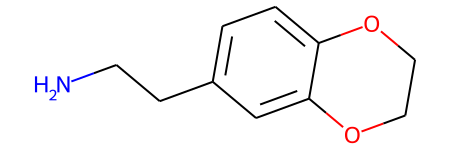

In [1100]:
m

In [1101]:
indigo_mol_to_test = Indigo().loadMolecule(smiles_to_test)

In [1102]:
%%time
fingerprint = pd.Series(bin_format(indigo_mol_to_test.fingerprint("sub").toString()))

CPU times: user 2.2 ms, sys: 1.88 ms, total: 4.08 ms
Wall time: 3.5 ms


In [1103]:
fingerprint.index = fingerprint.index.astype(str)

In [1104]:
fingerprint[fingerprint == 1].index

Index(['32', '38', '39', '41', '45', '47', '53', '54', '58', '82',
       ...
       '3694', '3698', '3703', '3705', '3726', '3727', '3731', '3733', '3734',
       '3735'],
      dtype='object', length=556)

# Prepare database

In [343]:
mols = Chem.MultithreadedSDMolSupplier('./119697.sdf', numWriterThreads=10)

In [344]:
mols = [m for m in mols]

In [1048]:
df = pd.read_csv("fingerprints_119697.txt", sep=" ", names=['id', 'fingerprint'], index_col=0)

In [898]:
def bin_format(number, num_of_bits=3736):
    return list(map(int, list(bin(int(number, 16))[2:].zfill(num_of_bits))))

In [1049]:
df['fingerprint'] = df['fingerprint'].apply(bin_format)

In [1050]:
split_df = pd.DataFrame(df['fingerprint'].tolist())

KeyboardInterrupt: 

In [8]:
split_df.to_csv('fingerprints.csv')

In [1051]:
df.fingerprint

id
26000020    [0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...
26000026    [0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...
26000033    [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...
26000039    [0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...
26000046    [0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...
                                  ...                        
26499992    [0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...
26499994    [0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...
26499995    [0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...
26499999    [0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...
26500000    [0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...
Name: fingerprint, Length: 119697, dtype: object

In [1054]:
X = df.fingerprint.to_list()

# Solution using KD Tree / Ball Tree

In [1133]:
def pairwise_and(x, y):
    return np.bitwise_and(x, y)

In [1236]:
%%time
# tree = BallTree(X, leaf_size=2, metric='kulsinski')
tree = BallTree(X, leaf_size=2, metric='russellrao')

CPU times: user 1min 4s, sys: 1.72 s, total: 1min 6s
Wall time: 1min 6s


In [1226]:
k = 6

In [1227]:
%%time
dist, ind = tree.query([fingerprint], k=k)   

CPU times: user 502 ms, sys: 2.51 ms, total: 504 ms
Wall time: 503 ms


In [1237]:
for idx, (i, d) in enumerate(zip(ind[0], dist[0])):
    if f(X[i]) >= 556:
        print(idx, i, f(X[i]), d)

0 16343 556 0.8511777301927195
1 56984 556 0.8511777301927195
2 56983 556 0.8511777301927195
3 56981 556 0.8511777301927195
4 56975 556 0.8511777301927195
5 56982 556 0.8511777301927195
6 56971 556 0.8511777301927195
7 56978 556 0.8511777301927195
8 56422 556 0.8511777301927195
9 28955 556 0.8511777301927195
10 16369 556 0.8511777301927195
11 11237 556 0.8511777301927195
12 16383 556 0.8511777301927195
13 40508 556 0.8511777301927195
14 14999 556 0.8511777301927195
15 44579 556 0.8511777301927195
16 16344 556 0.8511777301927195
17 43595 556 0.8511777301927195
18 10172 556 0.8511777301927195
19 33549 556 0.8511777301927195
20 160 556 0.8511777301927195
21 14578 556 0.8511777301927195
22 7749 556 0.8511777301927195
23 20847 556 0.8511777301927195
24 20278 556 0.8511777301927195
25 33550 556 0.8511777301927195
26 16345 556 0.8511777301927195
27 44485 556 0.8511777301927195
28 11735 556 0.8511777301927195
29 8791 556 0.8511777301927195
30 15004 556 0.8511777301927195
31 35544 556 0.8511777

In [1228]:
imgs = [Chem.Draw.MolToImage(mols[i]) for i in ind[0]]

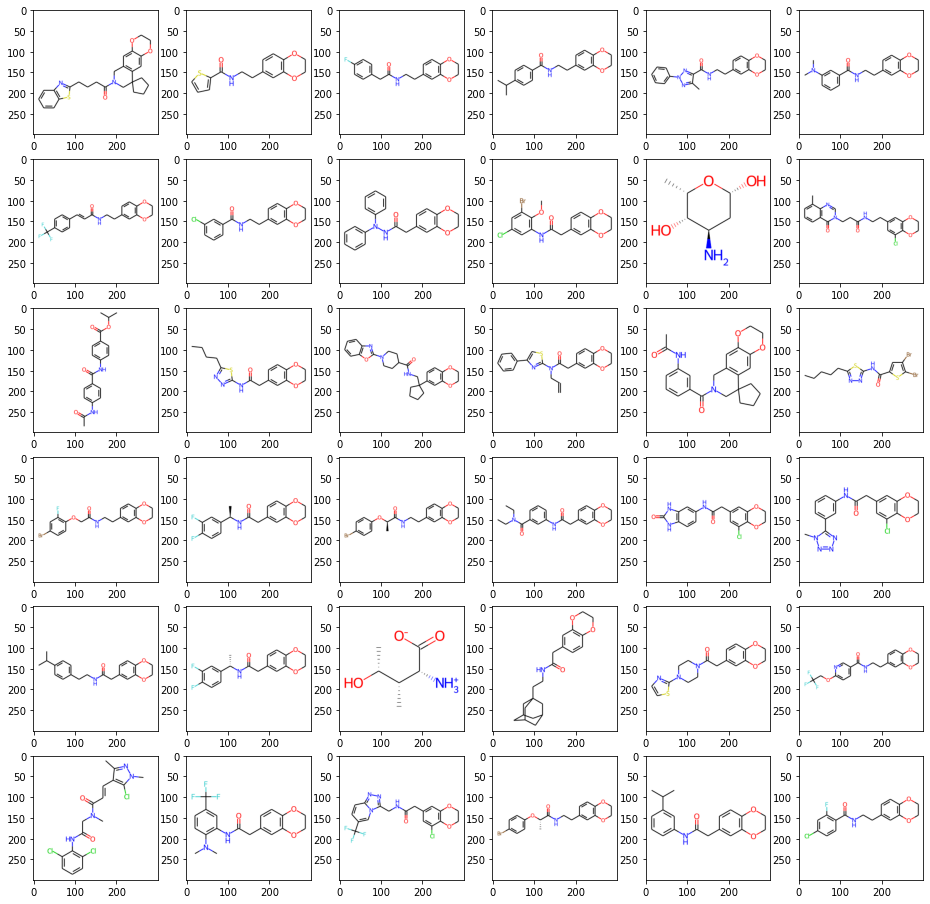

In [1229]:
_, axs = plt.subplots(k, k, figsize=(16, 16))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

In [1073]:
tree.valid_metrics

['euclidean',
 'l2',
 'minkowski',
 'p',
 'manhattan',
 'cityblock',
 'l1',
 'chebyshev',
 'infinity',
 'seuclidean',
 'mahalanobis',
 'wminkowski',
 'hamming',
 'canberra',
 'braycurtis',
 'matching',
 'jaccard',
 'dice',
 'kulsinski',
 'rogerstanimoto',
 'russellrao',
 'sokalmichener',
 'sokalsneath',
 'haversine',
 'pyfunc']

# Build tree for searching

In [3]:
split_df = pd.read_csv("fingerprints.csv", index_col=0)

In [1020]:
df = split_df

In [1021]:
df = df.T.drop_duplicates().T

In [1022]:
df.head()

,594,3354,2894,3447,2854,3547,3051,3176,3321,2955,...,2976,3061,3427,3541,3085,3593,3514,3623,0,1628
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [1023]:
LEAF_IND = -1 

In [1024]:
class Tree:
    def __init__(self, ind, left, right, df_index):
        self.ind = ind
        self.left = left
        self.right = right
        self.df_index = df_index
        
    def __iter__(self):
        return self.preorder
    
    def is_leaf(self):
        return self.ind == LEAF_IND
    
    @property
    def preorder(self):
        if self.left:
            yield from self.left
        yield self
        if self.right:
            yield from self.right
            
    def search(self, fingerprint):
        if self.is_leaf():
            return self.df_index
        print(self.ind, fingerprint.loc[self.ind])
        if fingerprint.loc[self.ind] == 1:
            if self.right:
                return self.right.search(fingerprint)
            return pd.Index()
        left_index = self.left.search(fingerprint)
        right_index = self.right.search(fingerprint)
        return left_index.union(right_index)

In [1025]:
def split_by_mean(df_index, used_ind, value_to_split=0.5):
    sv = df.loc[df_index, ~df.columns.isin(used_ind)].mean().sort_values()
    ind_to_split = sv.idxmin() #sv.index[sv.searchsorted(sv.max() * value_to_split)]
    col_values = df.loc[df_index, ind_to_split]
    df_index_0 = df_index[col_values == 0]
    df_index_1 = df_index[col_values == 1]
    return df_index_0, df_index_1, ind_to_split

In [1026]:
def build_tree(df_index, batch_size, used_ind, value_to_split=0.5, depth=100):
    if df_index.size <= batch_size or depth == 0:
        return Tree(LEAF_IND, None, None, df_index)
    df_index_0, df_index_1, ind_to_split = split_by_mean(df_index, used_ind, value_to_split)
    used_ind.append(ind_to_split)
    left = build_tree(df_index_0, batch_size, list(used_ind), value_to_split, depth - 1)
    right = build_tree(df_index_1, batch_size, list(used_ind), value_to_split, depth - 1)
    return Tree(ind_to_split, left, right, None)

In [1027]:
%%time
tree = build_tree(df.index, 3, [], 0.1, 2500)

CPU times: user 4h 9min 28s, sys: 1min 51s, total: 4h 11min 19s
Wall time: 7h 56min 46s


In [1029]:
%%time
result = tree.search(fingerprint)

1628 0
0 0
3623 0
3514 0
3593 0
3085 0
3427 0
3541 0
3061 0
2984 0
2976 0
3576 0
3363 0
2964 0
3614 0
3560 0
3093 0
3645 0
2897 0
3508 0
3145 0
3482 0
3418 0
2858 0
3565 0
3192 0
3220 0
3709 0
3619 0
3374 0
3322 0
3258 0
3685 0
3234 0
3711 0
3589 0
3097 0
2925 0
3326 0
3198 0
3604 0
3664 0
3295 0
3474 0
3208 0
3143 0
2850 0
3475 0
3463 0
3284 0
3530 0
3666 0
582 0
3142 0
2982 0
231 0
2907 0
3299 0
3173 0
3601 0
521 0
3671 0
108 0
1403 0
2805 0
3573 0
3034 0
3538 0
3286 0
2788 1
3425 0
3017 0
3368 0
3087 0
3343 0
701 0
3622 0
14 0
1116 0
2926 0
3557 0
3524 0
3119 0
3367 0
3032 0
3378 0
3510 0
3699 0
2967 0
3592 0
253 0
3515 0
3637 0
2801 0
97 0
3172 0
190 0
2932 0
3046 0
3048 0
3007 0
3018 0
3465 0
1423 0
3111 0
3329 0
3073 0
1395 0
1133 0
3056 0
2895 0
3201 0
3308 0
2837 0
2997 0
2825 0
446 0
3241 0
3626 0
2885 0
3121 0
3064 0
3583 0
3379 0
3467 0
3692 0
3651 0
668 0
106 0
3689 0
76 0
1143 0
178 0
260 0
1179 0
3055 0
1156 0
1209 0
2866 0
517 0
1046 0
3162 0
1202 0
885 0
113 0
1419 0
95

654 0
916 0
3572 0
444 0
1559 0
1613 0
1546 0
2800 0
3702 0
1530 0
3659 0
1618 0
1075 1
1077 0
317 0
1007 0
3324 0
941 0
503 0
3596 0
589 0
3423 0
1251 0
2927 0
244 0
1157 0
3218 0
230 0
817 0
573 1
3708 0
1077 0
466 0
1007 0
3458 0
941 0
3548 0
3719 0
1598 0
998 0
3479 0
3225 0
1581 0
3701 0
3535 0
1572 0
2794 0
3029 0
3449 0
3395 0
2864 0
3497 0
3277 0
24 0
1321 0
919 0
2879 0
3291 0
1566 0
2853 0
3342 0
1431 0
458 0
3532 0
948 0
3349 0
3221 0
1565 0
2784 0
2802 0
123 0
2917 0
2900 0
648 0
329 0
1554 0
1289 0
916 0
3440 0
2800 0
3240 0
2956 0
937 0
666 0
1365 0
816 0
3265 0
808 0
1535 0
2991 0
3398 0
541 0
402 0
1505 0
897 0
1473 0
1567 0
3319 0
2896 0
700 0
2928 0
3185 0
307 0
1187 0
3578 0
530 0
61 0
3260 0
574 0
727 0
2892 0
3420 0
25 0
3383 0
3292 0
1494 0
2937 0
498 0
3684 0
463 0
2978 0
89 0
3493 0
1543 0
689 0
866 0
2872 0
3024 0
1519 0
1596 0
1367 0
338 0
3399 0
3140 0
496 0
1183 0
630 0
1302 0
1172 0
3341 0
3405 0
3165 0
559 0
1117 0
832 0
605 0
3485 0
1086 0
795 0
1305 0
12

1266 0
1 0
632 0
3669 0
1393 0
3682 0
3586 0
1424 0
707 0
1397 0
60 0
3612 0
3437 0
678 0
1260 0
3647 0
51 0
686 0
2834 0
2862 0
1095 0
1246 0
1447 0
629 0
3213 0
207 0
3674 0
1499 0
630 0
1241 0
1520 0
510 0
3537 0
3122 0
199 0
1128 0
1144 0
3608 0
311 0
1338 0
3485 0
3106 0
3314 0
883 0
3025 0
681 0
3504 0
738 0
3704 0
3399 0
3165 0
622 0
3429 0
1455 0
84 0
3114 0
1437 0
2781 0
1298 0
3624 0
836 0
1057 0
64 0
1514 0
504 0
321 0
3611 0
777 0
1117 0
1543 0
202 0
2978 0
832 0
3493 0
370 0
943 0
3561 0
3684 0
463 0
1142 0
2928 0
2896 0
307 0
2872 0
3319 0
3024 0
1563 0
1244 0
725 0
897 0
1243 0
1505 0
402 0
1567 0
3398 0
457 0
191 0
1519 0
90 0
1461 0
1065 0
3629 0
1295 0
3157 0
816 0
3710 0
795 0
3440 0
1596 0
61 0
1290 0
522 0
3732 0
937 0
25 0
3260 0
574 0
3240 0
2917 0
1362 0
651 0
3578 0
329 0
2991 0
648 0
338 0
496 0
3393 0
123 0
3405 0
2956 0
2919 0
1305 0
3341 0
458 0
3079 0
2853 0
326 0
2900 0
1367 0
3337 0
1365 0
3342 0
1172 0
3291 0
3728 0
3221 0
2879 0
2802 0
1572 0
2794 0
34

431 0
155 0
1044 1
977 0
1135 0
166 1
484 0
2952 0
1235 0
570 0
188 0
1093 0
1221 1
3558 0
3486 0
839 0
399 1
170 0
3047 1
1477 1
3667 0
3380 1
1275 0
1110 0
1042 0
608 0
275 0
527 1
3096 0
846 0
655 0
1444 1
3372 1
717 0
314 0
979 0
3373 0
87 1
3316 0
28 0
1008 0
3154 0
840 0
836 0
705 0
1159 0
678 0
156 0
673 0
3490 0
1334 1
488 1
205 0
252 1
1185 0
1417 1
3063 0
3453 1
3502 0
698 0
239 0
206 1
1251 0
957 0
303 0
3433 0
3702 0
184 1
1182 1
1366 0
479 0
722 0
1308 0
591 1
685 0
3072 0
39 1
3717 0
3498 1
1585 0
775 0
3092 1
3243 1
1546 0
3364 0
40 0
699 0
994 0
482 0
2843 1
72 0
662 0
197 0
1236 0
742 0
1227 1
3551 0
1584 0
1250 1
114 0
285 0
800 0
467 0
1272 1
738 0
50 0
3677 1
3171 0
74 0
286 0
3086 0
412 1
2977 0
334 0
491 1
898 1
93 0
1470 0
1390 0
373 0
116 0
1243 0
1136 0
905 0
587 1
452 0
3231 1
85 0
272 0
539 0
3182 1
1498 0
702 0
752 1
676 1
774 0
3512 0
3708 0
200 0
466 0
3075 0
3458 0
3548 0
3719 0
614 0
1598 0
657 0
998 0
3479 0
639 0
1260 0
443 0
1205 0
3213 0
565 0
134 0


3395 0
780 0
859 0
269 0
1411 0
615 0
3661 0
57 0
24 0
1186 0
919 0
205 0
255 0
2847 0
728 0
546 0
3297 0
3634 0
2852 0
109 0
1431 0
3 0
565 0
330 0
355 0
3345 0
1525 0
492 0
56 0
703 0
3349 0
3437 0
1533 0
1499 0
654 0
3021 0
1021 0
393 0
1546 0
363 0
381 0
516 0
916 0
3473 0
2800 0
3476 0
788 0
1175 0
3214 0
3430 0
666 0
2904 0
263 0
468 0
853 0
1475 0
994 0
1602 0
3311 0
3279 0
986 0
482 0
541 0
1617 0
1621 0
850 0
2881 0
3632 0
1466 0
127 0
476 0
837 0
1473 0
131 0
43 0
3205 0
700 0
1382 0
3185 0
91 0
1187 0
2821 0
3655 0
1375 0
530 0
66 0
1355 0
662 0
37 0
1199 0
2865 0
3520 0
3169 0
379 0
878 0
1247 0
179 0
835 0
3129 0
2974 0
368 0
254 0
1494 0
1311 0
742 0
1236 0
89 0
1480 0
333 0
1380 0
3331 0
1244 0
486 0
1594 0
999 0
2959 0
954 0
595 0
1183 0
857 0
827 0
3597 0
130 0
455 0
202 0
513 0
219 0
1142 0
1269 0
946 0
3081 0
164 0
3170 0
1392 0
992 0
822 0
2810 0
257 0
3127 0
80 0
411 0
834 0
1139 0
298 0
1086 0
27 0
274 0
3714 0
1575 0
762 0
1107 0
787 0
2988 0
877 0
3657 0
315 0
1

3694 1
718 0
1224 1
3616 0
851 1
3110 1
3031 1
2920 1
3083 1
1526 1
915 0
288 1
623 1
3445 0
3621 0
2995 0
4 0
3397 0
2815 0
3553 1
145 1
185 0
843 0
2793 1
375 1
318 0
3391 0
3415 0
1108 1
3627 1
1420 1
409 0
1303 0
3500 1
6 0
3250 0
3705 1
3340 1
1426 1
2791 0
388 1
768 1
3039 0
765 1
3035 1
3422 1
3233 1
3296 0
3294 1
616 1
1203 0
3215 1
922 0
82 1
2957 0
3588 0
550 0
1497 1
1171 0
300 0
3066 0
1510 0
3526 0
2870 0
1207 1
3186 0
2961 0
1208 1
3339 0
598 1
3361 0
2807 0
1284 0
3477 1
2918 1
2911 0
3002 0
3088 1
3318 1
2812 1
3727 1
2844 0
3283 1
3439 1
1232 0
2954 1
2943 1
755 1
3569 0
2944 1
1400 0
3678 1
3729 0
3552 0
3010 0
1052 1
3434 0
3662 0
115 1
2941 0
3625 0
3128 1
2987 0
3460 0
1481 0
1153 1
1512 0
2859 1
1487 0
1432 0
2898 1
3595 0
2786 1
2999 1
3668 0
2969 1
63 0
2968 1
3387 1
3004 0
3446 0
972 0
2857 1
3707 0
3052 1
963 0
195 0
3455 0
895 1
3675 1
3266 1
3384 0
3332 1
3060 1
3450 0
1532 0
3676 1
359 0
2906 0
250 0
3640 1
531 0
3026 1
2994 0
2785 1
2848 1
3631 0
389 1
301

1606 0
1411 0
3408 0
551 0
1140 0
826 0
3137 0
1165 0
2868 0
536 0
279 0
2847 0
65 0
3364 0
1472 0
759 0
899 0
985 0
872 0
492 0
1293 0
772 0
868 0
1280 0
672 0
518 0
186 0
631 0
1546 0
348 0
3076 0
3633 0
579 0
198 0
1437 0
3480 0
407 0
1041 0
2974 0
1380 0
835 0
1342 0
2888 0
884 0
3452 0
1507 0
3714 0
609 0
1197 0
197 0
3311 0
1474 0
3414 0
3608 0
742 0
3196 0
40 0
1205 0
1126 0
2881 0
565 0
802 0
493 0
769 0
453 0
1343 0
1125 0
913 0
57 0
3432 0
1186 0
3230 0
1016 0
880 0
1004 0
971 0
1061 0
66 0
3473 0
788 0
1317 0
37 0
2824 0
1240 0
2993 0
126 0
3632 0
1562 0
306 0
3129 0
128 0
993 0
1623 0
2940 0
3 0
3634 0
118 0
3205 0
36 0
606 0
544 0
1382 0
1292 0
131 0
445 0
91 0
1499 0
524 0
34 0
122 0
3404 0
650 0
101 0
1585 0
72 0
966 0
1199 0
328 0
2818 0
662 0
812 0
1019 0
1130 0
3597 0
105 0
822 0
1615 0
494 0
134 0
3081 0
349 0
721 0
3577 0
289 0
3628 0
3309 0
3027 0
735 0
1488 0
1557 0
743 0
240 0
3478 0
3691 0
1370 0
1287 0
1413 0
464 0
917 0
243 0
3090 0
3501 0
3331 0
555 0
509 0
8

637 0
1390 0
3184 0
1586 0
1527 0
2852 0
3562 0
355 0
920 0
94 0
818 0
729 0
3362 0
1600 0
1325 0
1385 0
1243 0
51 0
3270 0
2938 0
3160 0
3432 0
1309 0
3211 0
425 0
3170 0
369 0
992 0
228 0
1110 0
2993 0
3238 0
3722 0
3396 0
3655 0
1122 0
363 0
1489 0
394 0
543 0
1443 0
251 0
508 0
1539 0
883 0
386 0
3634 0
1584 0
1107 0
3 0
292 0
1260 0
443 0
3350 0
1324 0
678 0
1356 0
3213 0
1015 0
1159 0
1404 0
3448 0
156 0
1357 0
1314 0
956 0
1005 0
942 0
714 0
3020 0
719 0
533 0
3212 0
1478 0
3543 0
1346 0
73 0
836 0
840 0
1337 0
3527 0
291 0
1167 0
1259 0
1200 0
3489 0
504 0
774 0
1008 0
370 0
1262 0
162 0
525 0
1515 0
1239 0
3459 0
256 0
236 0
814 0
275 0
896 0
2998 0
28 0
3316 0
516 0
163 0
1319 0
3042 0
1409 0
226 0
1553 0
71 0
358 0
1435 0
1194 0
280 0
742 0
1256 0
210 0
176 0
510 0
437 0
3724 0
1465 0
1053 0
3050 0
392 0
811 0
1563 0
1136 0
507 0
2780 0
1113 0
1002 0
725 0
1396 0
1509 0
3104 0
3333 0
2873 0
945 0
567 0
67 0
1009 0
177 0
547 0
1056 0
15 0
1020 0
81 0
931 0
905 0
1574 0
1616 0

44 0
3311 0
644 0
3414 0
556 0
661 0
309 0
1613 0
1035 0
1126 0
1476 0
493 0
163 0
453 0
3315 0
1125 0
1194 0
1004 0
735 0
3336 0
841 0
3268 0
1045 0
385 0
98 0
1433 0
580 0
1273 0
148 0
1177 0
509 0
390 0
563 0
1030 0
1437 0
3480 0
242 0
306 0
1120 0
544 0
1470 0
1292 0
1469 0
773 0
1428 0
537 0
1088 0
194 0
1054 0
1405 0
1611 0
3525 0
3257 0
3404 0
186 0
1592 0
3298 0
3487 0
690 0
101 0
2992 0
1540 0
2790 0
1466 0
52 0
2915 0
2945 0
1474 0
445 0
2818 0
681 0
812 0
211 0
371 0
562 0
1130 0
1587 0
946 0
516 0
772 0
3237 0
3025 0
3196 0
1562 0
2829 0
164 0
1376 0
2950 0
262 0
1615 0
560 0
993 0
849 0
3049 0
1253 0
913 0
192 0
3432 0
1386 0
2924 0
1019 0
801 0
229 0
1370 0
1242 0
1413 0
3161 0
917 0
569 0
1092 0
3446 0
1307 0
3004 0
1541 0
369 0
3090 0
3429 0
3331 0
1493 0
674 0
287 0
128 0
554 0
3 0
1246 0
343 0
1006 0
1335 0
3360 0
2912 0
265 0
3648 0
3151 0
49 0
687 0
1508 0
1338 0
2959 0
352 0
871 0
1137 0
268 0
702 0
1131 0
3476 0
86 0
95 0
118 0
1290 0
3691 0
1475 0
3236 0
3408 0
3

235 0
3167 0
442 0
3629 0
3256 0
1295 0
69 0
807 0
2951 0
1430 0
1050 0
3180 0
1530 0
716 0
1434 0
1583 0
797 0
3424 0
3135 0
1038 0
392 0
1158 0
1618 0
723 0
403 0
3513 0
3411 0
3464 0
3358 0
943 0
232 0
931 0
258 0
1586 0
1424 0
181 0
766 0
2878 0
1204 0
820 0
552 0
522 0
1539 0
860 0
3519 0
495 0
628 0
962 0
3586 0
136 0
238 0
596 0
2834 0
1020 0
372 0
964 0
686 0
1401 0
1239 0
3647 0
967 0
1091 0
380 0
129 0
216 0
207 0
794 0
2814 0
1524 0
949 0
819 0
2974 0
1110 0
94 0
1062 0
835 0
384 0
212 0
179 0
3271 0
3481 0
1568 0
1144 0
1149 0
3503 0
1244 0
744 0
976 0
3582 0
3123 0
1372 0
1264 0
2901 0
2811 0
1200 0
3612 0
290 0
813 0
1258 0
280 0
3416 0
944 0
3199 0
199 0
1014 0
3114 0
3270 0
3564 0
311 0
90 0
414 0
3643 0
441 0
568 0
1378 0
3704 0
99 0
3554 0
3050 0
1056 0
321 0
781 0
977 0
2958 0
798 0
3179 0
1336 0
3106 0
691 0
3485 0
370 0
1609 0
3561 0
3333 0
1241 0
622 0
1274 0
1206 0
3209 0
3435 0
1461 0
1290 0
629 0
3152 0
84 0
64 0
3669 0
319 0
1298 0
707 0
1305 0
1216 0
795 0
32

1474 0
683 1
3480 0
348 0
282 0
583 0
1297 0
344 0
593 0
1166 0
687 0
1447 0
554 0
1495 0
914 1
1242 0
3040 1
305 0
1345 0
1591 0
849 0
562 0
3310 0
497 0
315 0
2992 0
713 0
912 0
390 0
98 0
187 0
841 0
3360 0
2924 0
3008 0
1476 0
573 1
137 0
1157 0
975 1
237 1
3724 0
751 0
896 0
1238 1
1601 0
3527 0
1167 0
2936 0
880 0
911 0
1053 0
1296 0
638 0
2826 0
3594 0
1556 0
77 0
431 0
155 0
1044 1
1135 0
166 1
484 0
888 0
2952 0
1235 0
1228 0
570 0
1093 0
1221 1
1527 0
3558 0
3486 0
839 0
399 1
170 0
3047 1
1477 1
3667 0
3380 1
1275 0
608 0
275 0
527 1
3096 0
3113 0
846 0
1102 0
655 0
2838 0
1444 1
3372 1
717 0
177 0
3373 0
87 1
3316 0
28 0
1356 0
1008 0
3154 0
836 0
1159 0
678 0
156 0
673 0
3490 0
1334 1
488 1
252 1
1185 0
1417 1
3063 0
3453 1
2862 0
60 0
3502 0
698 0
206 1
1251 0
957 0
303 0
3433 0
3702 0
184 1
1182 1
1366 0
479 0
722 0
1308 0
591 1
685 0
3072 0
39 1
3717 0
3498 1
2849 0
775 0
3092 1
3243 1
255 0
2852 0
654 0
1546 0
3364 0
40 0
699 0
994 0
482 0
2843 1
131 0
72 0
662 0
197 0

3634 0
826 0
1045 0
615 0
3661 0
492 0
57 0
1186 0
24 0
3697 0
1201 0
867 0
1090 0
1347 0
405 0
118 0
1431 0
620 0
546 0
3297 0
3349 0
3633 0
899 0
109 0
3204 0
330 0
479 0
376 0
56 0
285 0
1437 0
1369 0
1554 0
1475 0
3414 0
1421 0
3360 0
1499 0
572 0
122 0
2800 0
1621 0
2881 0
2914 0
127 0
1021 0
393 0
3069 0
1342 0
381 0
666 0
467 0
328 0
663 0
1175 0
3214 0
263 0
1082 0
541 0
1355 0
2846 0
37 0
2821 0
400 0
597 0
257 0
2818 0
3520 0
812 0
379 0
3102 0
772 0
2950 0
3129 0
50 0
1177 0
3027 0
743 0
1150 0
1229 0
1413 0
313 0
917 0
3090 0
3331 0
1489 0
3720 0
563 0
1157 0
1508 0
2959 0
3568 0
912 0
262 0
3169 0
3674 0
1131 0
644 0
773 0
537 0
254 0
1311 0
1112 0
1480 0
700 0
337 0
3185 0
187 0
1187 0
439 0
530 0
3170 0
1520 0
1594 0
841 0
1120 0
727 0
233 0
3420 0
455 0
1173 0
401 0
2792 0
270 0
1494 0
2790 0
498 0
1571 0
3488 0
1332 0
1147 0
1280 0
1376 0
164 0
3008 0
3030 0
681 0
3127 0
3369 0
3504 0
222 0
27 0
3325 0
3714 0
3441 0
1452 0
1308 0
3298 0
2910 0
1190 0
2933 0
2779 0
3197

2989 0
3588 0
232 0
1036 0
1406 0
1335 0
37 0
508 0
212 0
1032 0
644 0
711 0
1455 0
836 0
1324 0
3611 0
1219 0
3624 0
13 0
1097 0
1078 0
534 0
1211 0
884 0
1113 0
507 0
3281 0
3080 0
1471 0
695 0
1410 0
1346 0
1422 0
251 0
1177 0
1443 0
1186 0
728 0
1312 0
154 0
187 0
1612 0
148 0
241 0
1105 0
3091 0
814 0
2780 0
1256 0
1388 0
3373 0
393 0
1409 0
209 0
652 0
3464 0
840 0
560 0
1509 0
567 0
67 0
3096 0
2873 0
46 0
628 0
238 0
81 0
1616 0
1563 0
1150 0
708 0
834 0
892 0
181 0
254 0
956 0
226 0
3065 0
510 0
256 0
1002 0
3537 0
3710 0
3178 0
442 0
839 0
3154 0
504 0
584 0
140 0
1280 0
1376 0
164 0
70 0
3028 0
416 0
1042 0
36 0
3714 0
1197 0
2965 0
172 0
962 0
62 0
3305 0
320 0
3436 0
596 0
1377 0
1020 0
275 0
1401 0
1011 0
162 0
2792 0
1470 0
1088 0
1456 0
28 0
3316 0
2790 0
302 0
276 0
133 0
1314 0
1248 0
151 0
168 0
861 0
3457 0
3358 0
766 0
1091 0
3558 0
233 0
1023 0
976 0
1132 0
1246 0
744 0
1235 0
291 0
757 0
3587 0
1340 0
3218 0
807 0
2951 0
1149 0
390 0
3180 0
716 0
3434 0
1295 0
15

570 0
188 0
240 0
338 0
1505 0
816 0
3718 0
1596 0
893 0
937 0
1515 0
1519 0
3024 0
1093 0
222 0
1147 0
387 0
3323 0
638 0
1124 0
3398 0
1535 0
714 0
3265 0
3714 0
1097 0
793 0
2981 0
402 0
1365 0
1358 0
1563 0
2851 0
697 0
2956 0
756 0
3240 0
1467 0
3276 0
3440 0
135 0
689 0
3219 0
3732 0
1397 0
470 0
1543 0
938 0
2917 0
1266 0
3690 0
632 0
3342 0
2887 0
1341 0
319 0
123 0
251 0
3351 0
33 0
1346 0
153 0
2853 0
3005 0
1289 0
1566 0
956 0
2900 0
3696 0
370 0
2861 0
207 0
12 0
3291 0
1321 0
706 0
1218 0
2879 0
422 0
534 0
458 0
2896 0
216 0
2794 0
3578 0
136 0
624 0
522 0
820 0
1572 0
3663 0
3535 0
3449 0
948 0
1144 0
1192 0
368 0
602 0
1424 0
3493 0
3479 0
1581 0
1066 0
998 0
9 0
3355 0
574 0
307 0
3278 0
2784 0
2886 0
1442 0
361 0
3221 0
1598 0
910 0
3458 0
3254 0
3548 0
220 0
3719 0
2919 0
3428 0
3708 0
1415 0
3695 0
1275 0
2974 0
34 0
1219 0
1623 0
3661 0
532 0
57 0
1081 0
3218 0
3249 0
3561 0
1536 0
1589 0
114 0
441 0
859 0
1137 0
3313 0
1409 0
2884 0
1267 0
2973 0
2881 0
1187 0
327

1393 0
798 0
3416 0
813 0
602 0
896 0
1206 0
556 0
1338 0
3297 0
1458 0
321 0
740 0
1066 0
416 0
563 0
455 0
1067 0
3106 0
686 0
873 0
552 0
820 0
331 0
3457 0
622 0
1202 0
90 0
1461 0
1139 0
777 0
1175 0
971 0
207 0
3714 0
1298 0
3587 0
3669 0
3130 0
1197 0
2782 0
795 0
1054 0
1305 0
2804 0
860 0
522 0
1361 0
477 0
1117 0
3196 0
559 0
2829 0
3529 0
3012 0
1303 0
3408 0
84 0
3485 0
629 0
832 0
3179 0
3430 0
289 0
113 0
236 0
492 0
1186 0
57 0
1169 0
1388 0
1132 0
496 0
3509 0
110 0
3718 0
1000 0
1174 0
476 0
95 0
1001 0
757 0
338 0
3661 0
3216 0
1367 0
982 0
454 0
1596 0
3195 0
3684 0
417 0
3323 0
759 0
632 0
1519 0
2990 0
282 0
619 0
1339 0
198 0
3480 0
3024 0
242 0
3314 0
3091 0
2872 0
1543 0
938 0
3630 0
3493 0
689 0
2978 0
448 0
463 0
1350 0
596 0
136 0
950 0
3679 0
3594 0
3292 0
133 0
25 0
486 0
2937 0
2892 0
918 0
1436 0
1019 0
574 0
3260 0
839 0
1092 0
1307 0
1541 0
871 0
1137 0
630 0
2834 0
361 0
818 0
3612 0
3690 0
906 0
1152 0
3578 0
2896 0
31 0
168 0
838 0
307 0
423 0
261 0


457 0
673 0
3285 0
1050 0
1407 0
961 0
3667 0
322 0
1530 0
1618 0
3041 0
644 0
267 0
3358 0
3189 0
931 0
766 0
848 0
988 0
1194 0
997 0
3224 0
1265 0
3300 0
1282 0
608 0
3310 0
1127 0
857 0
1115 0
285 0
730 0
376 0
451 0
599 0
839 0
40 0
631 0
2856 0
699 0
75 0
994 0
3364 0
1472 0
3558 0
3728 0
1470 0
129 0
1562 0
654 0
2814 0
1546 0
1440 0
1524 0
1093 0
188 0
200 0
570 0
192 0
2971 0
735 0
1162 0
946 0
584 0
3461 0
588 0
292 0
687 0
614 0
3641 0
3151 0
265 0
657 0
3473 0
503 0
996 0
3324 0
3624 0
1503 0
1091 0
1228 0
1149 0
1077 0
805 0
1007 0
976 0
2952 0
888 0
556 0
1281 0
3371 0
504 0
414 0
3643 0
3225 0
3504 0
2790 0
1135 0
2958 0
3123 0
3029 0
977 0
3395 0
1258 0
1082 0
907 0
24 0
1081 0
3218 0
431 0
1014 0
1166 0
919 0
3154 0
1008 0
344 0
1290 0
2868 0
1431 0
551 0
3532 0
3152 0
3349 0
3408 0
1565 0
3100 0
1331 0
886 0
821 0
331 0
548 0
3253 0
1063 0
1374 0
3594 0
336 0
3610 0
1533 0
1554 0
3638 0
363 0
215 0
916 0
1531 0
3281 0
2989 0
1296 0
1053 0
2800 0
833 0
823 0
3653 0
286

3722 0
362 0
3238 0
2992 0
3426 0
713 0
874 0
155 0
1453 0
818 0
1015 0
364 0
1270 0
721 0
3121 0
193 0
578 0
2797 0
1408 0
3310 0
1127 0
871 0
1030 0
447 0
48 0
1466 0
734 0
508 0
1382 0
2826 0
549 0
2783 0
638 0
215 0
1447 0
1410 0
566 0
652 0
1495 0
1548 0
534 0
1341 0
3670 0
1269 0
287 0
3543 0
1443 0
245 0
371 0
711 0
741 0
241 0
3079 0
1038 0
291 0
1524 0
400 0
2846 0
1061 0
1539 0
3519 0
1143 0
956 0
1571 0
172 0
3177 0
1394 0
1387 0
1424 0
3611 0
3241 0
1027 0
954 0
504 0
730 0
285 0
1008 0
1262 0
814 0
1337 0
3457 0
3587 0
1162 0
226 0
486 0
46 0
2873 0
1459 0
749 0
192 0
305 0
3211 0
100 0
1601 0
3065 0
246 0
725 0
1563 0
394 0
706 0
1331 0
3404 0
1386 0
325 0
2998 0
3710 0
133 0
2818 0
1091 0
1228 0
1579 0
3309 0
3536 0
924 0
3451 0
523 0
3713 0
682 0
613 0
809 0
1210 0
3572 0
1290 0
1028 0
3152 0
1214 0
3025 0
991 0
319 0
70 0
1255 0
3305 0
571 0
1312 0
26 0
65 0
154 0
276 0
1236 0
717 0
515 0
2924 0
465 0
3315 0
861 0
302 0
849 0
3679 0
3371 0
3406 0
882 0
3613 0
1388 0
87

1312 0
1128 0
298 0
1005 0
1076 0
262 0
989 0
2904 0
1390 0
907 0
2820 0
3154 0
1419 0
3333 0
1170 0
1583 0
1266 0
1445 0
3135 0
1190 0
697 0
3125 0
1455 0
885 0
3101 0
790 0
114 0
198 0
3063 0
953 0
715 0
3568 0
151 0
1348 0
517 0
1165 0
716 0
595 0
1415 0
3393 0
567 0
1113 0
927 0
507 0
1185 0
3337 0
470 0
3690 0
443 0
1555 0
1226 0
3430 0
814 0
1467 0
3612 0
320 0
1122 0
3396 0
3329 0
730 0
820 0
1347 0
199 0
1402 0
3473 0
431 0
1159 0
368 0
94 0
1066 0
152 0
673 0
2983 0
694 0
1317 0
249 0
1260 0
213 0
311 0
872 0
1228 0
3106 0
124 0
3554 0
1209 0
1580 0
3179 0
777 0
686 0
216 0
1120 0
1336 0
248 0
192 0
1592 0
267 0
207 0
3529 0
3647 0
632 0
3300 0
3682 0
141 0
30 0
629 0
2790 0
1231 0
84 0
3241 0
1397 0
810 0
3158 0
958 0
1562 0
1107 0
1046 0
3314 0
813 0
3371 0
258 0
3021 0
608 0
1405 0
721 0
102 0
477 0
536 0
655 0
3341 0
1169 0
832 0
1117 0
729 0
110 0
1305 0
484 0
1404 0
3429 0
286 0
891 0
1540 0
148 0
2958 0
3123 0
592 0
76 0
392 0
181 0
651 0
766 0
1264 0
3587 0
1342 0
1474

99 0
1565 0
1067 0
3564 0
2993 0
1594 0
612 0
916 0
1382 0
2800 0
52 0
3561 0
682 0
1100 0
1274 0
3713 0
100 0
883 0
438 0
627 0
3096 0
57 0
1473 0
387 0
3185 0
497 0
3152 0
1331 0
405 0
1290 0
118 0
64 0
396 0
1210 0
109 0
1494 0
2992 0
319 0
634 0
1288 0
690 0
713 0
270 0
1141 0
1017 0
91 0
3263 0
72 0
3086 0
1576 0
993 0
619 0
626 1
27 0
3714 0
3008 0
1197 0
2790 0
1036 0
212 0
877 0
3617 0
1288 0
2832 0
1041 0
1139 0
2924 0
782 0
2792 0
1291 0
979 0
1170 0
362 0
1270 0
1325 0
2980 0
3667 0
1530 0
1621 0
3063 0
3287 0
1184 0
3490 0
1402 0
1064 0
681 0
533 0
3213 0
719 0
923 0
678 0
1331 0
485 0
1287 0
3486 0
762 0
1159 0
1188 0
3558 0
3429 0
783 0
3274 0
3028 0
129 0
396 0
109 0
887 0
3257 0
1185 0
1455 0
840 0
2940 0
2992 0
690 0
1016 0
34 0
1073 0
1514 0
504 0
959 0
3154 0
3504 0
3195 0
3433 0
646 0
1553 0
1356 0
162 0
780 0
222 0
2993 0
404 0
28 0
3316 0
612 0
774 0
1472 0
1546 0
1256 0
210 0
3373 0
507 0
1113 0
1396 0
634 0
3599 0
1509 0
567 0
1191 0
3371 0
599 0
3275 0
370 0
10

1308 0
49 0
1139 0
1291 0
3224 0
770 0
827 0
639 0
437 0
94 0
1540 0
84 0
130 0
3384 0
1524 0
36 0
489 0
396 0
25 0
485 0
743 0
608 0
3507 0
541 0
919 0
492 0
3561 0
695 0
708 0
2906 0
987 0
1335 0
2811 0
3478 0
129 0
684 0
1437 0
117 0
1507 0
625 0
517 0
1521 0
2911 0
1190 0
1621 0
141 0
1466 0
818 0
833 0
3267 0
1138 0
445 0
647 0
627 0
1036 0
1428 0
3567 0
946 0
965 0
1353 0
196 0
3116 0
3367 0
1139 0
3557 0
3512 0
3379 0
27 0
2874 0
3714 0
3515 0
2962 0
2825 0
1240 0
3609 0
3041 0
1585 0
1366 0
290 0
3478 0
1287 0
818 0
3501 0
715 0
1173 0
1499 0
306 0
1160 0
337 0
3674 0
808 0
439 0
438 0
524 0
101 0
1540 0
1520 0
823 0
3171 0
916 0
3202 0
772 0
401 0
1164 0
2910 0
1187 0
1470 0
3424 0
2792 0
1069 0
1565 0
3349 0
3269 0
460 0
1146 0
1431 0
234 0
728 0
3648 0
1216 0
49 0
761 0
2959 0
3435 0
803 0
59 0
3158 0
3121 0
831 0
1511 0
3028 0
727 0
3086 0
3146 0
3190 0
1448 0
3125 0
1264 0
3007 0
286 0
387 0
2912 0
265 0
572 0
1421 0
817 0
109 0
1394 0
3263 0
1109 0
3364 0
162 0
563 0
858 

1477 1
2788 1
2788 1
2788 1
2788 1
2788 1
461 1
3379 0
2788 1
3448 0
3379 0
2788 1
54 1
221 0
3379 0
2788 1
3379 0
2788 1
3379 0
221 0
2788 1
435 0
1602 0
353 0
3379 0
2788 1
435 0
3379 0
2788 1
3379 0
435 0
2788 1
3379 0
456 0
435 0
1536 0
679 0
60 0
1382 0
142 0
221 0
1109 0
804 0
884 0
442 0
2973 0
1471 0
3125 0
1503 0
1176 0
936 0
179 0
236 0
140 0
461 1
3379 0
1394 0
1092 0
3728 0
1021 0
353 0
524 0
817 0
1137 0
1602 0
1472 0
298 0
1185 0
221 0
3721 0
853 0
1576 0
933 0
173 0
3019 0
98 0
461 1
328 0
3379 0
2788 1
3396 0
328 0
643 0
3042 0
1227 1
516 0
217 1
217 1
217 1
764 0
217 1
122 0
764 0
34 0
3379 0
2788 1
122 0
34 0
3379 0
2788 1
290 0
479 0
345 1
3379 0
34 0
2788 1
3379 0
2788 1
3379 0
2788 1
1017 0
445 0
1191 0
3379 0
2788 1
1191 0
3379 0
1017 0
2788 1
634 0
1191 0
3379 0
1017 0
2788 1
118 0
3379 0
2788 1
118 0
3379 0
396 0
2788 1
3379 0
2788 1
405 0
1090 0
118 0
3379 0
396 0
2788 1
215 0
1180 0
685 0
118 0
3161 0
3313 0
3086 0
3159 0
3139 0
2838 0
404 0
3513 0
1147 0
634 

85 0
731 0
2800 0
319 0
162 0
532 0
539 0
3594 0
1121 0
693 0
229 0
1127 0
1439 0
945 0
485 0
958 0
1347 0
2846 0
400 0
663 0
438 0
50 0
3310 0
1151 0
830 0
489 0
2997 0
270 0
953 0
320 0
60 0
2832 0
849 0
3637 0
1160 0
1580 0
989 0
425 0
546 0
798 0
3333 0
326 0
152 0
80 0
369 0
233 0
3414 0
924 0
1142 0
56 0
818 0
1270 0
737 0
401 0
495 0
2901 0
3025 0
1047 0
287 0
1081 0
3249 0
3429 0
1266 0
3218 0
202 0
156 0
1073 0
334 0
3459 0
1256 0
1504 0
3724 0
2797 0
246 0
315 0
497 0
1338 0
3329 0
723 0
403 0
3048 0
3316 0
1568 0
57 0
3227 0
545 0
3525 0
1176 0
3633 0
1437 0
3257 0
37 0
3612 0
2811 0
129 0
380 0
3513 0
3488 0
627 0
639 0
396 0
2874 0
717 0
3271 0
631 0
1472 0
1586 0
719 0
3610 0
1390 0
1204 0
2983 0
3279 0
3301 0
943 0
1617 0
364 0
1434 0
373 0
665 0
1144 0
1066 0
3682 0
846 0
3536 0
1037 0
3451 0
2820 0
1430 0
736 0
1541 0
888 0
1255 0
3171 0
1594 0
3568 0
294 0
3647 0
1258 0
77 0
3529 0
116 0
2887 0
161 0
191 0
1362 0
3502 0
3519 0
672 0
3704 0
3592 0
253 0
255 0
357 0
839

3512 0
2788 1
1123 0
3512 0
2788 1
3512 0
2788 1
3512 0
1123 0
2788 1
3512 0
2788 1
3512 0
877 0
2788 1
35 0
1197 0
877 0
3714 0
1123 0
27 0
818 0
1315 1
1197 0
35 0
3714 0
3512 0
982 0
2974 0
546 0
818 0
835 0
1422 0
887 0
129 0
3488 0
179 0
627 0
121 0
437 0
1536 0
3693 0
1357 0
2973 0
1148 0
1216 0
742 0
330 0
275 0
1401 0
884 0
98 0
187 0
3301 0
1410 0
3437 0
1343 0
3435 0
830 0
74 0
1346 0
181 0
775 0
1186 0
1016 0
414 0
842 0
853 0
1142 0
1408 0
666 0
3464 0
3700 0
132 0
1039 0
1073 0
1219 0
665 0
208 0
1568 0
872 0
3157 0
1612 0
711 0
1160 0
241 0
3279 0
1170 0
1324 0
3587 0
1445 0
931 0
935 0
699 0
3214 0
3667 0
118 0
13 0
54 1
1197 0
3512 0
2788 1
3714 0
888 0
1197 0
2792 0
35 0
1088 0
658 0
416 0
512 0
1177 0
3628 0
1617 0
912 0
3594 0
818 0
1601 0
2790 0
400 0
3609 0
1538 0
557 0
1147 0
2849 0
633 0
1385 0
3149 0
1467 0
3498 1
3367 0
3512 0
2788 1
27 0
1315 1
731 0
3498 1
1139 0
3367 0
3512 0
30 0
926 0
633 0
1356 0
3101 0
881 0
742 0
626 1
3367 0
3211 0
1524 0
2814 0
626 1


3424 0
886 0
1277 0
3404 0
218 0
2952 0
364 0
1015 0
3490 0
1402 0
673 0
1090 0
3537 0
1601 0
156 0
3213 0
1260 0
1190 0
436 0
1411 0
2781 0
1017 0
3007 0
1252 0
961 0
70 0
731 0
3583 0
678 0
1141 0
805 0
3167 0
1348 0
846 0
353 0
154 0
2780 0
1043 0
1361 0
3125 0
776 0
962 0
989 0
2804 0
2819 0
611 0
302 0
1097 0
3113 0
3268 0
31 0
821 0
3714 0
665 0
1616 0
3172 0
1216 0
1099 0
1020 0
927 0
628 0
695 0
1362 0
3275 0
1366 0
3689 0
849 0
3558 0
720 0
1157 0
1027 0
740 0
261 0
945 0
1239 0
967 0
354 0
3081 0
1115 0
749 0
3358 0
328 0
1614 0
864 0
172 0
1438 0
3241 0
668 0
1456 0
3305 0
336 0
320 0
62 0
1243 0
3525 0
1377 0
794 0
819 0
489 0
1013 0
1094 0
1035 0
608 0
1011 0
228 0
1467 0
3033 0
386 0
30 0
684 0
157 0
2865 0
1525 0
209 0
437 0
578 0
3457 0
3587 0
539 0
1389 0
144 0
3503 0
390 0
830 0
1240 0
191 0
1140 0
860 0
1275 0
226 0
3065 0
256 0
510 0
1530 0
736 0
330 0
993 0
693 0
763 0
133 0
331 0
2951 0
1038 0
1406 0
602 0
1405 0
102 0
1340 0
152 0
3464 0
959 0
161 0
1273 0
2816 0

73 0
742 0
3042 0
3638 0
372 0
1107 0
3693 0
848 0
3134 0
2777 0
2989 0
2977 0
1142 0
3429 0
886 0
619 0
1086 0
665 0
188 0
1093 0
1575 0
3582 0
2909 0
1091 0
146 0
2988 0
373 0
2781 0
1429 0
3276 0
1251 0
1105 0
387 0
834 0
3492 0
3007 0
828 0
981 0
3462 0
3724 0
393 0
905 0
3174 0
381 0
2888 0
524 0
1297 0
759 0
3728 0
2881 0
3504 0
64 0
3025 0
3489 0
3345 0
319 0
995 0
1355 0
707 0
209 0
3435 0
761 0
445 0
1345 0
367 0
358 0
494 0
651 0
1536 0
1078 0
944 0
34 0
543 0
1600 0
1609 0
1578 0
3459 0
1422 0
3350 0
714 0
516 0
2959 0
280 0
1131 0
3138 0
3050 0
273 0
1538 0
3116 0
3212 0
1593 0
328 0
1357 0
1056 0
99 0
3564 0
1278 0
221 0
3410 0
3448 0
2938 0
121 0
837 0
1579 0
249 0
988 0
682 0
391 0
942 0
51 0
1364 0
3159 0
386 0
271 0
1216 0
655 0
579 0
1350 0
1472 0
2863 0
407 0
3091 0
852 0
3371 0
235 0
1274 0
3713 0
558 0
2832 0
94 0
366 0
695 0
282 0
508 0
753 0
515 0
993 0
46 0
2873 0
1460 0
40 0
1112 0
819 0
228 0
289 0
422 0
880 0
126 0
608 0
1515 0
194 0
1331 0
3209 0
3470 0
370 

3024 0
3055 0
1127 0
938 0
1561 0
979 0
1170 0
162 0
1037 0
1434 0
2852 0
1175 0
3241 0
1186 0
3159 0
1290 0
3684 0
3713 0
1530 0
956 0
632 0
1266 0
470 0
961 0
3682 0
1307 0
1397 0
46 0
3025 0
1616 0
25 0
3429 0
291 0
2851 0
1533 0
1472 0
3364 0
1601 0
100 0
1458 0
358 0
699 0
994 0
3279 0
631 0
1527 0
2780 0
361 0
423 0
3510 0
307 0
1152 0
3501 0
3373 0
3069 0
3578 0
2873 0
2896 0
838 0
67 0
1365 0
3537 0
937 0
3260 0
1331 0
1401 0
1555 0
962 0
596 0
1461 0
893 0
2811 0
3513 0
43 0
131 0
1567 0
3319 0
507 0
1229 0
3240 0
2956 0
1027 0
261 0
3018 0
363 0
2919 0
2900 0
3587 0
3457 0
1618 0
1505 0
3538 0
329 0
648 0
1001 0
2837 0
3179 0
2997 0
576 0
2784 0
1056 0
77 0
948 0
1439 0
1563 0
1456 0
1312 0
276 0
629 0
260 0
133 0
1358 0
402 0
1613 0
3564 0
3378 0
1535 0
816 0
62 0
827 0
835 0
179 0
2853 0
736 0
592 0
905 0
99 0
2991 0
1566 0
740 0
668 0
3265 0
1065 0
725 0
1448 0
12 0
2864 0
3343 0
2981 0
1289 0
502 0
3622 0
3637 0
80 0
3558 0
2967 0
3663 0
3629 0
372 0
2937 0
3701 0
1321 0


176 0
2989 0
1578 0
1147 0
1546 0
142 0
56 0
344 0
703 0
3170 0
2810 0
204 0
778 0
1287 0
3461 0
3041 0
975 1
3299 0
3512 0
217 1
3299 0
3512 0
2805 0
217 1
3299 0
34 0
1482 0
122 0
698 0
395 0
3613 0
217 1
122 0
1369 0
1003 0
217 1
3299 0
626 1
1369 0
3299 0
626 1
3299 0
1369 0
3512 0
626 1
3299 0
3512 0
2805 0
2788 1
3299 0
3243 1
1017 0
3299 0
206 1
3299 0
1589 0
542 1
3299 0
3512 0
2805 0
2788 1
3299 0
1191 0
3512 0
1017 0
2805 0
445 0
2788 1
634 0
109 0
3299 0
3512 0
1017 0
2805 0
445 0
2788 1
109 0
3299 0
3512 0
2805 0
2788 1
3299 0
3512 0
634 0
2805 0
2788 1
3299 0
109 0
692 0
634 0
1482 0
1191 0
1253 0
417 0
641 0
237 1
396 0
118 0
109 0
3299 0
634 0
3512 0
239 0
3613 0
1017 0
1092 0
588 0
206 1
118 0
396 0
405 0
109 0
3299 0
3512 0
2805 0
1191 0
2788 1
3299 0
239 0
395 0
698 0
109 0
1339 0
634 0
1281 0
3613 0
265 0
1191 0
206 1
3299 0
165 0
1249 0
1260 0
443 0
109 0
346 0
678 0
365 0
3213 0
1159 0
634 0
756 0
1404 0
436 0
1314 0
2915 0
3371 0
3297 0
911 0
1240 0
881 0
3730 0
8

938 0
3162 0
2978 0
3538 0
786 0
3479 0
1414 0
998 0
3578 0
191 0
457 0
2942 0
2917 0
3278 0
3048 0
61 0
948 0
3355 0
2886 0
3221 0
2919 0
1543 0
3493 0
3428 0
2784 0
3286 0
3018 0
3719 0
1116 0
3260 0
3663 0
3312 0
220 0
1581 0
3458 0
253 0
3573 0
265 0
714 0
3073 0
3046 0
3111 0
1415 0
2801 0
3254 0
3441 0
758 0
949 0
685 0
882 0
631 0
3448 0
3452 0
579 0
233 0
60 0
3472 0
3689 0
3079 0
1002 0
612 0
3161 0
1539 0
662 0
744 0
1575 0
226 0
426 0
3691 0
1342 0
452 0
3725 0
710 0
2904 0
1467 0
2951 0
439 0
881 0
1142 0
3582 0
842 0
1129 0
3393 0
176 0
1421 0
1076 0
563 0
700 0
3337 0
415 0
1611 0
1054 0
3583 0
3178 0
35 0
877 0
1576 0
235 0
142 0
650 0
819 0
537 0
3661 0
3383 0
461 1
2982 0
3299 0
3512 0
1343 0
3404 0
817 0
1210 0
2797 0
1290 0
981 0
105 0
1314 0
822 0
1253 0
1389 0
729 0
3461 0
363 0
3025 0
743 0
1047 0
3287 0
1299 0
319 0
372 0
204 0
1192 0
764 0
34 0
1270 0
197 0
425 0
369 0
672 0
3211 0
114 0
3069 0
2993 0
366 0
3624 0
314 0
221 0
797 0
1488 0
281 0
850 0
942 0
867 0

912 0
555 0
303 0
560 0
2790 0
842 0
805 0
1541 0
3426 0
1147 0
1405 0
3257 0
336 0
3504 0
222 0
681 0
3638 0
817 0
892 0
641 0
387 0
907 0
315 0
2989 0
497 0
3310 0
1127 0
634 0
3610 0
2915 0
567 0
1476 0
1035 0
3410 0
1078 0
116 0
280 0
1437 0
1106 0
1602 0
3273 0
921 0
27 0
977 0
3615 0
3157 0
781 0
958 0
173 0
386 0
73 0
981 0
993 0
764 0
1007 0
1385 0
1064 0
217 1
978 1
978 1
3087 0
3557 0
3142 0
3379 0
3017 0
2788 1
3087 0
1003 0
3702 0
2993 0
646 0
3693 0
449 1
3087 0
3557 0
651 0
669 1
3087 0
3557 0
3142 0
3379 0
3017 0
2788 1
1264 0
796 1
3087 0
651 0
3360 0
3315 0
3096 0
3113 0
1478 0
566 0
1340 0
1264 0
493 0
3670 0
1235 0
543 0
3710 0
935 0
2952 0
1159 0
1030 0
1136 0
269 0
1223 0
1579 0
3461 0
822 0
85 0
700 0
13 0
305 0
192 0
255 0
1249 0
1056 0
3108 0
264 1
3087 0
351 0
1164 0
172 0
2973 0
1337 0
814 0
761 0
1038 0
1101 0
174 1
204 0
196 0
85 0
106 0
176 0
2965 0
1511 0
554 0
923 0
205 0
1246 0
122 0
3154 0
2912 0
1216 0
3344 1
3087 0
3557 0
3142 0
3677 1
3087 0
3557 0
1

1385 0
532 0
499 0
28 0
203 0
3050 0
1136 0
48 0
3310 0
1127 0
86 0
474 1
35 0
1197 0
2982 0
3671 0
3557 0
341 0
3243 1
1197 0
35 0
2982 0
3671 0
564 0
3216 0
2849 0
633 0
1261 0
1225 1
1197 0
2982 0
3671 0
1287 0
877 0
3501 0
1123 0
29 0
3478 0
1160 0
818 0
1585 0
775 0
1522 0
1341 0
3673 1
3714 0
1197 0
699 0
35 0
3527 0
1227 1
1200 0
1472 0
1197 0
1585 0
35 0
3158 0
380 0
363 0
44 0
690 0
818 0
336 0
523 0
1180 0
1270 0
3313 0
1570 0
382 0
644 0
1175 0
1287 0
1160 0
1064 0
2909 0
775 0
859 0
1575 0
566 0
381 0
3653 0
93 0
543 0
1036 0
212 0
1609 0
1216 0
691 0
784 0
781 0
3462 0
715 0
1074 0
3568 0
1229 0
3697 0
1366 0
671 0
1474 0
263 0
479 0
119 0
1162 0
1111 0
3065 0
3019 0
1099 0
1614 0
3169 0
1533 0
2958 0
65 0
170 0
2847 0
1136 0
837 0
491 1
2982 0
3671 0
217 1
2982 0
3671 0
3557 0
582 0
3379 0
3714 0
2805 0
1164 0
737 0
2910 0
278 0
401 0
2790 0
1334 1
2982 0
3087 0
3671 0
1498 0
3480 0
887 0
1201 0
1250 1
834 0
2982 0
3087 0
3671 0
3557 0
27 0
582 0
3379 0
285 0
283 1
2982 0

2909 0
826 0
1498 0
1015 0
3702 0
699 0
3279 0
2934 0
927 0
935 0
567 0
799 0
452 0
1465 0
959 0
177 0
168 0
1382 0
1599 1
3087 0
3671 0
3530 0
3367 0
1139 0
3557 0
1315 1
3087 0
1236 0
803 0
1273 0
187 0
1287 0
1471 0
1139 0
3257 0
454 0
485 0
1242 0
1122 0
566 0
879 0
543 0
218 0
3170 0
611 0
1073 0
302 0
3714 0
3637 0
787 0
1466 0
3421 0
1065 0
3667 0
1023 0
456 0
3513 0
3211 0
1418 0
1214 0
2819 0
1615 0
1267 0
679 0
3459 0
299 0
1458 0
1190 0
774 0
2933 0
3633 0
517 0
384 0
2998 0
650 0
3178 0
1240 0
1391 0
46 0
326 0
3551 0
1362 0
1244 0
1151 0
2792 0
3717 0
3611 0
317 0
2927 0
740 0
1381 0
3065 0
3063 0
394 0
1441 0
151 0
786 0
271 0
538 0
533 0
437 0
927 0
3702 0
1586 0
1183 0
830 0
797 0
780 0
130 0
1394 0
644 0
699 0
702 0
3629 0
3256 0
612 0
685 0
3313 0
1111 0
662 0
72 0
823 0
947 0
2800 0
3157 0
570 0
861 0
405 0
438 0
3306 0
3273 0
175 0
751 0
3567 0
3300 0
939 0
165 0
986 0
1401 0
292 0
1293 0
199 0
602 0
109 0
3114 0
272 0
209 0
1382 0
43 0
121 0
2988 0
711 0
3281 0
106

3274 0
665 0
140 0
3041 0
312 0
392 0
651 0
3205 0
1184 0
639 0
73 0
964 0
1402 0
3189 0
95 0
1380 0
2938 0
100 0
1601 0
999 0
3121 0
1488 0
3062 0
59 0
3213 0
857 0
1260 0
443 0
1617 0
368 0
1458 0
2856 0
2781 0
373 0
1404 0
398 0
404 0
436 0
1036 0
1416 0
3091 0
663 0
3279 0
203 0
836 0
840 0
3624 0
758 0
1200 0
981 0
544 0
1292 0
55 0
1478 0
3154 0
584 0
149 0
3275 0
1262 0
200 0
3715 0
1356 0
162 0
3075 0
532 0
1276 0
457 0
643 0
3169 0
657 0
3001 0
3643 0
1374 0
989 0
202 0
27 0
878 0
1623 0
776 0
2977 0
1256 0
210 0
3572 0
604 0
1094 0
444 0
1231 0
3102 0
507 0
486 0
99 0
1113 0
1396 0
802 0
165 0
2939 0
1343 0
822 0
801 0
567 0
1009 0
3225 0
1387 0
177 0
547 0
485 0
979 0
1301 0
1170 0
1583 0
1445 0
314 0
555 0
3029 0
1330 0
118 0
396 0
3507 0
1578 0
3602 0
509 0
1448 0
717 0
1307 0
708 0
1024 0
1161 0
1331 0
64 0
919 0
3513 0
3315 0
694 0
1163 0
1508 0
541 0
3020 0
3270 0
1167 0
906 0
1101 0
1431 0
2933 0
1350 0
454 0
982 0
3659 0
417 0
31 0
60 0
204 0
1565 0
1204 0
1215 0
142 

2907 0
3671 0
818 0
29 0
1473 0
242 0
1522 0
270 0
1270 0
1381 0
35 0
625 0
1507 0
1342 0
1575 0
1376 0
753 0
713 0
3364 0
1472 0
984 0
980 1
2982 0
2907 0
176 0
1578 0
818 0
781 0
2806 1
2982 0
877 0
2907 0
1123 0
3671 0
3284 0
1241 0
1556 0
512 0
3333 0
636 0
77 0
3358 0
1396 0
468 0
3410 0
691 0
650 0
1240 0
3609 0
273 0
557 0
284 0
802 0
2849 0
769 0
3212 0
633 0
1112 0
567 0
1509 0
1105 0
255 0
783 0
1357 0
208 0
325 0
971 0
3108 0
883 0
380 0
3195 0
1557 0
1339 0
162 0
440 0
2912 0
3021 0
737 0
947 0
3313 0
1476 0
2910 0
3643 0
1057 0
867 0
426 0
694 0
484 0
242 0
695 0
980 1
35 0
1197 0
877 0
2982 0
2907 0
3671 0
818 0
1252 0
3123 0
1258 0
1270 0
155 0
306 0
3243 1
1197 0
35 0
3714 0
877 0
27 0
1123 0
2982 0
818 0
2907 0
1270 0
3671 0
3284 0
730 0
1064 0
953 0
1421 0
285 0
802 0
3721 0
376 0
298 0
1196 0
1243 0
3270 0
1576 0
116 0
1451 0
620 0
1136 0
1347 0
1201 0
3617 0
1025 0
3594 0
3472 0
704 0
2826 0
1210 0
1154 0
971 0
1291 0
1577 0
192 0
1016 0
638 0
1001 0
215 0
365 0
159

1162 0
1088 0
822 0
769 0
1275 0
3130 0
1504 0
289 0
305 0
1386 0
1130 0
812 0
1379 0
229 0
248 0
1346 0
3481 0
464 0
1408 0
303 0
265 0
629 0
821 0
1258 0
448 0
74 0
633 0
1302 0
197 0
431 0
3641 0
421 0
130 0
1554 0
1305 0
3717 0
3158 0
3072 0
263 0
1129 0
3329 0
207 0
99 0
3171 0
653 0
477 0
3472 0
238 0
3050 0
1090 0
42 0
3230 0
3690 0
644 0
559 0
405 0
441 0
337 0
1186 0
113 0
57 0
634 0
1142 0
76 0
290 0
479 0
1592 0
1076 0
104 0
1507 0
26 0
572 0
3341 0
3668 0
833 0
1421 0
3488 0
1172 0
2967 0
3702 0
1357 0
863 0
630 0
3161 0
771 0
2872 0
915 0
3270 0
1042 0
846 0
1288 0
3718 0
1291 0
1110 0
25 0
100 0
536 0
281 0
580 0
1008 0
3484 0
1380 0
3189 0
3487 0
3466 0
589 0
338 0
501 0
1136 0
532 0
1019 0
2782 0
1188 0
1111 0
3695 0
2965 0
1529 0
239 0
395 0
291 0
1418 0
1175 0
3027 0
539 0
2863 0
814 0
692 0
266 0
1314 0
2838 0
1389 0
1488 0
1409 0
2963 0
480 0
3010 0
1616 0
3480 0
3529 0
880 0
3048 0
3569 0
632 0
568 0
1374 0
944 0
3101 0
295 0
75 0
93 0
1480 0
36 0
64 0
736 0
1232 0

3638 0
3543 0
495 0
213 0
610 0
547 0
3570 0
2933 0
177 0
3501 0
3473 0
1381 0
3170 0
1351 0
3125 0
1063 0
1557 0
3461 0
964 0
1387 0
356 0
131 0
681 0
657 0
503 0
679 0
457 0
3007 0
1043 0
3670 0
428 0
2838 0
1496 0
1611 0
2867 0
1191 0
3371 0
456 0
247 0
315 0
717 0
1240 0
3151 0
1319 0
1324 0
562 0
652 0
1080 0
3053 0
1338 0
3478 0
650 0
647 0
1054 0
3253 0
1094 0
1256 0
726 0
1379 0
3509 0
3139 0
1293 0
517 0
758 0
460 0
828 0
636 0
1401 0
219 0
625 0
705 0
1021 0
1175 0
1371 0
98 0
3617 0
193 0
55 0
3246 0
1555 0
1150 0
2868 0
1055 0
761 0
346 0
641 0
778 0
227 0
694 0
3430 0
1577 0
34 0
3184 0
3138 0
473 0
332 0
1504 0
3077 0
981 0
3679 0
133 0
2904 0
40 0
165 0
1184 0
876 0
3466 0
756 0
363 0
801 0
729 0
3448 0
1130 0
799 0
1302 0
303 0
1480 0
369 0
270 0
1024 0
856 0
501 0
782 0
713 0
1368 0
1601 0
646 0
2939 0
555 0
415 0
429 0
1209 0
1363 0
1062 0
3554 0
1343 0
3195 0
835 0
651 0
1374 0
3106 0
1336 0
434 0
371 0
1298 0
1375 0
1589 0
663 0
366 0
742 0
946 0
2928 0
423 0
384 0


2850 0
295 0
2907 0
3284 0
3379 0
461 1
1602 0
2890 0
2850 0
2907 0
3284 0
3613 0
1564 1
1602 0
2850 0
2890 0
2907 0
221 0
3284 0
295 0
3379 0
3306 0
3273 0
1500 0
353 0
737 0
3251 0
3364 0
1472 0
1546 0
929 0
1188 0
1194 0
3021 0
528 1
2850 0
1602 0
2907 0
2890 0
3284 0
605 0
272 0
817 0
1251 0
295 0
589 0
440 0
833 0
1053 0
192 0
3257 0
1592 0
713 0
669 1
2850 0
2907 0
3284 0
3379 0
2890 0
1229 0
221 0
3146 0
313 0
50 0
295 0
558 0
3231 1
353 0
1513 0
2850 0
2907 0
1602 0
3284 0
2890 0
3379 0
221 0
278 0
3721 0
328 0
1181 1
2850 0
2907 0
3284 0
1015 0
3728 0
3615 0
1154 0
2890 0
1345 0
221 0
1591 0
756 0
2781 0
1503 0
1386 0
1458 0
1623 0
3424 0
1005 0
1064 0
376 0
368 0
451 0
3274 0
325 0
3040 1
328 0
516 0
2850 0
2907 0
353 0
3284 0
3697 0
810 0
3396 0
879 0
2890 0
1122 0
1495 0
3597 0
764 0
1293 0
1561 0
1334 1
2850 0
2907 0
3284 0
3655 0
1375 0
3389 1
2850 0
516 0
2907 0
328 0
3284 0
1513 0
3379 0
3125 0
565 0
1313 0
3067 1
2850 0
634 0
2907 0
1191 0
3284 0
3407 0
944 0
995 0
137

3463 0
339 1
164 0
3463 0
339 1
3463 0
2850 0
2907 0
3284 0
1098 1
3463 0
2850 0
800 0
164 0
3069 0
2988 0
1366 0
3127 0
787 0
634 0
1191 0
267 0
445 0
1369 0
597 0
626 1
1280 0
3463 0
395 0
2973 0
164 0
1529 0
782 0
81 0
3205 0
967 0
3269 0
2887 0
3648 0
1459 0
865 0
908 0
456 0
3683 0
1109 0
2838 0
309 0
1197 0
74 0
480 0
243 0
3315 0
3256 0
3092 1
1141 0
3463 0
2850 0
2907 0
2832 0
35 0
699 0
1238 1
3463 0
2850 0
2907 0
3284 0
3557 0
3475 0
3142 0
3512 0
582 0
3379 0
2805 0
1533 0
1199 0
949 0
834 0
864 0
1139 0
651 0
91 0
1382 0
27 0
1265 0
2988 0
242 0
3714 0
546 0
1197 0
1262 0
1096 0
3040 1
1287 0
3478 0
3501 0
69 0
3256 0
3659 0
1469 0
1378 0
781 0
3007 0
1296 0
711 0
1564 1
3463 0
2850 0
1141 0
2907 0
3284 0
3557 0
3475 0
3142 0
164 0
3512 0
339 1
1522 0
3463 0
2850 0
1141 0
2907 0
3671 0
1317 0
1504 0
3155 0
3643 0
447 0
1197 0
166 1
3463 0
2850 0
2907 0
3671 0
1141 0
3284 0
1280 0
3557 0
3475 0
3142 0
3512 0
582 0
339 1
455 0
3463 0
2850 0
2907 0
3671 0
3284 0
3557 0
3475 0


897 0
630 0
3398 0
893 0
3551 0
2991 0
1244 0
1124 0
95 0
1365 0
3351 0
3538 0
662 0
1443 0
1612 0
251 0
2981 0
632 0
1545 0
1505 0
3457 0
260 0
557 0
284 0
51 0
2852 0
3240 0
2784 0
910 0
2919 0
3411 0
408 0
949 0
370 0
3342 0
33 0
942 0
729 0
612 0
3249 0
723 0
3421 0
329 0
3343 0
1218 0
3696 0
2849 0
153 0
12 0
1321 0
121 0
937 0
838 0
3032 0
1133 0
2853 0
3271 0
384 0
3449 0
1424 0
97 0
719 0
3162 0
78 0
3622 0
702 0
3034 0
3701 0
394 0
926 0
3535 0
307 0
856 0
706 0
1158 0
1572 0
423 0
3479 0
3663 0
3629 0
2886 0
9 0
3355 0
1046 0
3278 0
2802 0
689 0
418 0
1038 0
3135 0
1295 0
2951 0
3601 0
1598 0
3286 0
716 0
1156 0
1403 0
3254 0
123 0
3548 0
2917 0
3323 0
3368 0
1367 0
3573 0
466 0
3046 0
3111 0
3666 0
521 0
1116 0
2788 1
1605 0
3143 0
3530 0
3475 0
3512 0
3285 0
2805 0
3017 0
2788 1
1605 0
1089 1
1089 1
475 1
746 0
3143 0
3530 0
1089 1
3143 0
3530 0
475 1
1375 0
3655 0
3389 1
461 1
3448 0
461 1
221 0
2890 0
295 0
1602 0
3448 0
3143 0
461 1
2890 0
3143 0
3530 0
295 0
3475 0
3448

3512 0
74 0
1513 0
1074 0
1146 0
848 0
591 1
764 0
217 1
764 0
3208 0
217 1
3208 0
764 0
2907 0
217 1
3208 0
2907 0
764 0
3530 0
3367 0
3512 0
516 0
582 0
2788 1
1017 0
445 0
3208 0
1369 0
2907 0
626 1
1017 0
3208 0
445 0
763 0
674 0
1309 0
1369 0
3313 0
947 0
822 0
34 0
350 0
3081 0
721 0
3677 1
3208 0
1017 0
2907 0
445 0
3530 0
1369 0
3367 0
626 1
109 0
3208 0
2907 0
3530 0
3367 0
3512 0
582 0
2788 1
3208 0
396 0
2907 0
3530 0
3367 0
634 0
3512 0
3293 0
269 0
1017 0
1249 0
445 0
3712 0
3243 1
118 0
405 0
396 0
1090 0
3208 0
2907 0
634 0
1045 0
564 0
187 0
663 0
2938 0
1017 0
213 0
1261 0
355 0
1003 0
3019 0
445 0
944 0
3204 0
479 0
626 1
405 0
1090 0
118 0
3208 0
2907 0
604 0
1180 0
523 0
1330 0
947 0
546 0
3297 0
3212 0
3072 0
1362 0
1272 1
1090 0
3208 0
2907 0
118 0
3530 0
3367 0
3512 0
109 0
582 0
2788 1
1090 0
3208 0
2907 0
975 1
3208 0
2907 0
3530 0
3367 0
3512 0
118 0
582 0
2788 1
3208 0
2907 0
3530 0
3367 0
3512 0
582 0
118 0
2788 1
612 0
3208 0
2907 0
3530 0
3367 0
405 0
3512

2850 0
1594 0
3664 0
1067 0
3143 0
1199 0
354 0
2804 0
791 1
3293 0
3279 0
1060 0
1192 0
1593 0
269 0
1249 0
1455 0
1035 0
1522 0
270 0
909 0
3628 0
650 0
694 0
1573 0
2843 1
1480 0
3463 0
3208 0
2850 0
1590 1
3463 0
1480 0
3208 0
2850 0
3664 0
2982 0
3143 0
2907 0
3671 0
3530 0
3367 0
233 0
3284 0
583 0
702 0
348 0
3633 0
26 0
1000 0
1498 0
949 0
239 0
50 0
662 0
431 0
87 1
3208 0
3143 0
3535 0
2907 0
3463 0
3474 0
3198 0
3326 0
2962 0
3512 0
3479 0
3671 0
3557 0
2982 0
3664 0
3295 0
3530 0
1116 0
3416 0
3586 0
3406 0
3142 0
1264 0
3073 0
9 0
2874 0
2926 0
3379 0
3308 0
3449 0
3428 0
582 0
998 0
3601 0
3312 0
3475 0
3221 0
2853 0
3573 0
2991 0
3341 0
3524 0
3622 0
374 1
2850 0
3087 0
3367 0
3284 0
35 0
3604 0
3299 0
2805 0
3017 0
1146 0
818 0
239 0
3401 0
395 0
1200 0
776 0
1011 0
2965 0
1480 0
572 0
2938 0
1378 0
3509 0
1012 0
1527 0
28 0
3316 0
1458 0
917 0
896 0
1042 0
1240 0
1095 0
67 0
909 0
271 0
3459 0
3564 0
790 0
1455 0
2915 0
1478 0
1335 0
584 0
1592 0
714 0
554 0
363 0
780 

740 0
398 0
3561 0
394 0
3305 0
916 0
121 0
3184 0
187 0
1536 0
1342 0
764 0
3710 0
1180 0
685 0
328 0
731 0
1097 0
606 0
239 0
78 0
291 0
469 0
168 0
579 0
358 0
548 0
2887 0
3396 0
3448 0
560 0
3424 0
1054 0
355 0
729 0
1099 0
1308 0
1431 0
722 0
744 0
3611 0
1533 0
363 0
370 0
1149 0
1366 0
3697 0
3204 0
67 0
778 0
707 0
1183 0
1065 0
1331 0
2865 0
3502 0
1228 0
272 0
3027 0
192 0
1370 0
1601 0
693 0
858 0
46 0
1317 0
306 0
1004 0
154 0
517 0
3180 0
3178 0
2998 0
188 0
498 0
152 0
102 0
1194 0
1482 0
999 0
692 0
942 0
51 0
3679 0
133 0
1128 0
2977 0
1000 0
1160 0
2856 0
1340 0
1143 0
341 0
929 0
1132 0
569 0
543 0
2938 0
393 0
1233 0
1167 0
549 0
958 0
762 0
1499 0
836 0
840 0
558 0
534 0
576 0
322 0
3279 0
1520 0
3647 0
810 0
3102 0
381 0
1115 0
1008 0
1384 0
1557 0
173 0
369 0
738 0
210 0
1410 0
986 0
263 0
931 0
614 0
3358 0
537 0
1356 0
1472 0
994 0
476 0
3674 0
26 0
507 0
410 0
1324 0
482 0
621 0
3310 0
613 0
964 0
1314 0
3205 0
151 0
924 0
334 0
868 0
36 0
1480 0
2983 0
992 0


267 0
3333 0
356 0
441 0
971 0
3167 0
1585 0
331 0
919 0
3594 0
234 0
704 0
120 0
1287 0
442 0
1204 0
3532 0
1090 0
405 0
2940 0
3324 0
112 0
675 0
1280 0
164 0
109 0
610 0
634 0
3401 0
1196 0
3159 0
1328 0
303 0
445 0
2971 0
1369 0
588 0
3702 0
3501 0
1096 0
34 0
661 0
3127 0
3484 0
80 0
406 0
834 0
1141 0
775 0
911 0
916 0
3269 0
2800 0
1101 0
823 0
157 0
666 0
996 0
1100 0
1216 0
808 0
1120 0
2782 0
1140 0
541 0
1350 0
438 0
1163 0
730 0
1421 0
3268 0
3473 0
28 0
1261 0
1077 0
503 0
580 0
1007 0
1445 0
1058 0
1187 0
501 0
1583 0
640 0
1407 0
3041 0
1605 0
3693 0
727 0
1068 0
3420 0
2884 0
3383 0
3019 0
36 0
140 0
3218 0
275 0
691 0
193 0
1020 0
781 0
988 0
1143 0
263 0
1375 0
3325 0
1002 0
323 0
1231 0
3502 0
3630 0
60 0
1176 0
200 0
947 0
2798 0
649 0
3313 0
353 0
3100 0
3072 0
1167 0
487 0
2938 0
100 0
1601 0
400 0
257 0
1609 0
1183 0
155 0
1496 0
1458 0
246 0
3163 0
295 0
2909 0
146 0
3256 0
1587 0
165 0
1255 0
69 0
1606 0
1378 0
3137 0
1125 0
269 0
176 0
3661 0
3462 0
332 0
3293

3163 0
543 0
1160 0
3480 0
886 0
3610 0
1228 0
41 1
2850 0
3664 0
289 0
566 0
1604 0
3670 0
1020 0
3305 0
1312 0
164 0
641 0
417 0
651 0
3211 0
480 0
105 0
3130 0
917 0
664 0
1488 0
1300 0
1419 0
1265 0
2990 0
3406 0
3101 0
132 0
1340 0
1192 0
1139 0
106 0
511 0
1555 0
229 0
514 0
27 0
693 0
3714 0
287 0
1197 0
1489 0
3586 0
876 0
263 0
2890 0
1601 0
2846 0
1362 0
729 0
818 0
355 0
1348 0
152 0
1477 1
2850 0
1296 0
1280 0
3551 0
3502 0
3209 0
1095 0
2862 0
1128 0
3453 1
2850 0
1272 1
2850 0
762 0
3130 0
196 0
1168 1
455 0
2850 0
3664 0
3711 0
3143 0
3671 0
3284 0
1280 0
3557 0
3475 0
3604 0
164 0
3599 0
653 0
1310 1
2850 0
3664 0
3711 0
3143 0
3671 0
3284 0
1141 0
3557 0
1280 0
3475 0
1376 0
3604 0
3142 0
582 0
3379 0
2805 0
3017 0
2788 1
2850 0
3664 0
3711 0
1522 0
2838 0
479 0
1350 0
631 0
40 0
1609 0
116 0
1623 0
1564 1
3256 0
691 0
69 0
1024 0
3435 0
1609 0
774 0
1129 0
1141 0
2819 0
3269 0
3325 0
796 1
2850 0
2843 1
2850 0
3664 0
942 0
3358 0
3256 0
1370 0
3113 0
1043 0
1522 0
137

1179 0
3198 0
3692 0
3557 0
3240 0
3337 0
3512 0
3173 0
2895 0
2962 0
3343 0
689 0
1442 0
2802 0
2982 0
3142 0
1519 0
3111 0
3073 0
2937 0
2784 0
686 0
437 0
574 0
1286 0
886 0
830 0
2861 0
2978 0
3277 0
2928 0
3601 0
3046 0
3719 0
3208 0
3689 0
25 0
3425 0
253 0
3515 0
2887 0
3405 0
1563 0
2874 0
2896 0
2878 0
3326 0
3399 0
3341 0
3524 0
559 0
1218 0
1596 0
3162 0
1423 0
893 0
2925 0
123 0
1515 0
3548 0
1210 0
168 0
1362 0
608 0
338 0
737 0
629 0
860 0
152 0
1365 0
622 0
1088 0
1243 0
2866 0
3063 0
1008 0
286 0
1038 0
920 0
729 0
470 0
1180 0
3696 0
1324 0
43 0
3504 0
1367 0
538 0
1147 0
2805 0
3516 0
3368 0
3157 0
1616 0
3025 0
1572 0
3130 0
508 0
3260 0
363 0
832 0
3123 0
944 0
94 0
723 0
576 0
1419 0
401 0
1393 0
1151 0
3718 0
2988 0
372 0
507 0
872 0
3568 0
246 0
744 0
652 0
3702 0
814 0
3578 0
3485 0
423 0
883 0
1065 0
3610 0
272 0
3502 0
292 0
3428 0
3351 0
3271 0
793 0
291 0
3364 0
1206 0
672 0
1112 0
3708 0
1226 0
3724 0
3497 0
602 0
879 0
692 0
1177 0
816 0
241 0
3478 0
2814 

220 0
2900 0
3284 0
3557 0
2780 0
781 0
3367 0
3337 0
3291 0
2850 0
3312 0
3592 0
190 0
2872 0
3319 0
3152 0
3399 0
3720 0
2965 0
3692 0
2837 0
2997 0
3425 0
696 0
3018 0
3583 0
3064 0
3622 0
3626 0
3378 0
3510 0
2967 0
3172 0
3160 0
3637 0
3515 0
574 0
2915 0
1566 0
3032 0
3201 0
3664 0
3295 0
3548 0
3224 0
668 0
633 0
3056 0
860 0
3055 0
231 0
582 0
2928 0
2983 0
1491 0
3351 0
3275 0
3674 0
907 0
3300 0
3173 0
3516 0
423 0
3704 0
2919 0
3007 0
3699 0
3587 0
3465 0
100 0
15 0
3238 0
3424 0
701 0
3657 0
1129 0
477 0
1572 0
910 0
1133 0
162 0
489 0
3157 0
3429 0
3169 0
3025 0
1367 0
1264 0
2991 0
2982 0
178 0
1305 0
1132 0
1147 0
711 0
3034 0
3046 0
3079 0
3241 0
997 0
1143 0
1586 0
2962 0
9 0
121 0
3538 0
3601 0
1403 0
1194 0
414 0
840 0
620 0
2895 0
3535 0
3044 0
154 0
3398 0
291 0
1598 0
3696 0
682 0
1003 0
1289 0
43 0
521 0
2801 0
1372 0
958 0
1117 0
1321 0
337 0
376 0
786 0
559 0
515 0
1323 0
1218 0
1356 0
1032 0
90 0
1210 0
1006 0
168 0
805 0
3205 0
876 0
1577 0
1524 0
657 0
1474 

608 0
1572 0
1377 0
714 0
748 0
1260 0
3478 0
2814 0
909 0
835 0
632 0
3329 0
654 0
3069 0
2788 1
238 0
495 0
1362 0
1068 0
275 0
1401 0
1380 0
3628 0
967 0
960 0
1517 0
507 0
1583 0
989 0
1042 0
1107 0
1239 0
1533 0
627 0
363 0
396 0
3185 0
1187 0
274 0
1086 0
1275 0
1546 0
1472 0
72 0
1199 0
857 0
42 0
282 0
643 0
706 0
1568 0
1313 0
1050 0
3695 0
3667 0
3197 0
1530 0
631 0
994 0
766 0
3140 0
866 0
3053 0
3113 0
3722 0
1429 0
499 0
709 0
130 0
202 0
931 0
708 0
1142 0
243 0
1562 0
677 0
1529 0
1109 0
533 0
1558 0
3564 0
949 0
653 0
233 0
286 0
3486 0
208 0
1500 0
2988 0
1121 0
569 0
3462 0
442 0
1353 0
3662 0
3407 0
962 0
655 0
1244 0
1293 0
129 0
1233 0
995 0
620 0
2868 0
549 0
114 0
3410 0
551 0
112 0
2939 0
1112 0
493 0
1538 0
2798 0
3408 0
3276 0
2838 0
485 0
3513 0
1311 0
953 0
1473 0
462 0
717 0
438 0
213 0
797 0
249 0
314 0
1247 0
530 0
1120 0
727 0
641 0
1331 0
3267 0
1560 0
966 0
773 0
1128 0
106 0
3362 0
1235 0
2952 0
671 0
204 0
1015 0
933 0
371 0
312 0
678 0
405 0
3075 0


168 0
1309 0
453 0
1043 0
1337 0
1042 0
428 0
77 0
3161 0
909 0
291 0
730 0
1421 0
197 0
179 0
1580 0
583 0
1579 0
994 0
3154 0
2914 0
467 0
702 0
800 0
572 0
3275 0
1487 0
3178 0
91 0
783 0
1521 0
3256 0
1016 0
1001 0
597 0
1127 0
3613 0
864 0
144 0
239 0
1595 0
944 0
3065 0
1082 0
736 0
267 0
810 0
1362 0
510 0
3501 0
812 0
3529 0
3457 0
2988 0
165 0
1123 0
924 0
257 0
3725 0
1482 0
692 0
408 0
1 0
3423 0
119 0
790 0
299 0
883 0
1539 0
42 0
661 0
939 0
1591 0
353 0
1057 0
3567 0
1562 0
354 0
543 0
3433 0
3702 0
325 0
64 0
1541 0
628 0
959 0
1456 0
1511 0
3632 0
355 0
1533 0
50 0
738 0
1312 0
1560 0
556 0
2819 0
3300 0
1340 0
1035 0
1546 0
3315 0
584 0
1148 0
841 0
554 0
178 0
1210 0
1540 0
2977 0
722 0
1447 0
73 0
706 0
3551 0
396 0
954 0
1293 0
3270 0
75 0
1243 0
710 0
1105 0
3478 0
2820 0
1498 0
632 0
425 0
321 0
1405 0
837 0
437 0
121 0
3629 0
1120 0
208 0
2992 0
69 0
3130 0
217 1
242 0
1135 0
3718 0
1267 0
824 0
3341 0
3209 0
1129 0
3501 0
1240 0
1336 0
321 0
77 0
1258 0
766 0
87

1520 0
401 0
3161 0
802 0
379 0
1111 0
439 0
337 0
196 0
443 0
1170 0
1495 0
814 0
396 0
132 0
408 0
109 0
398 0
3213 0
1246 0
1339 0
1518 0
1161 0
156 0
1323 0
479 0
265 0
218 0
1338 0
1166 0
369 0
229 0
2797 0
368 0
1557 0
1001 0
593 0
3195 0
193 0
646 0
347 0
1580 0
140 0
344 0
271 0
81 0
3211 0
612 0
1398 0
511 0
1350 0
256 0
24 0
919 0
3395 0
2890 0
525 0
759 0
138 0
120 0
1488 0
1313 0
997 0
244 0
904 0
1122 0
282 0
926 0
702 0
580 0
394 0
198 0
1437 0
1090 0
921 0
78 0
91 0
117 0
533 0
823 0
3683 0
880 0
719 0
3104 0
923 0
677 0
1100 0
261 0
1027 0
3506 0
861 0
363 0
460 0
2910 0
565 0
3725 0
3330 0
262 0
537 0
1003 0
1061 0
1054 0
788 0
2824 0
1428 0
233 0
1545 0
236 0
3632 0
1369 0
286 0
626 1
3664 0
3087 0
3234 0
724 0
858 0
303 0
438 0
1473 0
3273 0
3702 0
721 0
184 1
3664 0
3087 0
3234 0
3144 0
651 0
371 0
1003 0
1068 0
864 0
428 0
3714 0
1106 0
1381 0
1259 0
1538 0
1099 0
1517 0
3225 0
685 0
3429 0
2933 0
1308 0
1460 0
3725 0
261 0
643 0
1197 0
182 1
3664 0
3087 0
3234 0
1

223 1
3463 0
223 1
1422 0
130 0
563 0
559 0
1361 0
805 0
274 0
814 0
994 0
3271 0
40 0
384 0
631 0
1623 0
1144 0
1060 0
181 0
933 0
269 0
1169 0
1504 0
723 0
1097 0
1172 0
1152 0
447 0
846 0
1478 0
482 0
995 0
1472 0
560 0
905 0
44 0
830 0
662 0
238 0
879 0
1141 0
609 0
533 0
3292 0
76 0
1019 0
187 0
312 0
670 0
2850 0
216 0
2814 0
232 0
3682 0
1398 0
819 0
496 0
110 0
689 0
1032 0
1364 0
1576 0
207 0
3529 0
2992 0
2888 0
286 0
543 0
820 0
2978 0
3493 0
1546 0
695 0
3684 0
3664 0
338 0
272 0
729 0
490 0
497 0
714 0
355 0
3270 0
1243 0
255 0
418 0
243 0
1397 0
3612 0
1201 0
1136 0
1137 0
1329 0
99 0
926 0
629 0
514 0
3568 0
1295 0
1609 0
807 0
938 0
826 0
385 0
314 0
1346 0
982 0
454 0
1142 0
950 0
1505 0
897 0
3314 0
697 0
2900 0
1253 0
2977 0
292 0
46 0
435 0
3647 0
748 0
208 0
1073 0
70 0
3693 0
705 0
226 0
240 0
1309 0
1158 0
209 0
284 0
849 0
722 0
290 0
2861 0
1305 0
1380 0
3537 0
431 0
77 0
1132 0
671 0
438 0
303 0
687 0
1499 0
1066 0
75 0
3319 0
1120 0
1535 0
1416 0
81 0
3101 0


3463 0
3208 0
3619 0
3322 0
3234 0
3374 0
3326 0
3367 0
233 0
3709 0
3284 0
1478 0
1546 0
3189 0
1054 0
1405 0
270 0
3421 0
1141 0
3513 0
3702 0
1559 0
1376 0
303 0
75 0
467 0
2856 0
810 0
652 0
73 0
3182 1
91 0
72 0
887 0
230 0
1533 0
363 0
1594 0
683 1
3192 0
3463 0
3208 0
333 0
3619 0
1199 0
707 0
91 0
204 0
1382 0
1575 0
721 0
486 0
1573 0
1279 1
1201 0
1293 0
518 0
826 0
1160 0
266 0
80 0
3496 0
2952 0
888 0
3269 0
3435 0
333 0
3280 0
775 0
691 0
877 0
665 0
818 0
73 0
886 0
1325 0
1359 0
1219 0
3383 0
3420 0
3461 0
781 0
2781 0
1078 0
1594 0
3256 0
1067 0
1016 0
971 0
1378 0
646 0
269 0
2993 0
3293 0
978 1
3192 0
3463 0
3208 0
1527 0
3305 0
3451 0
99 0
3141 0
3072 0
1160 0
3501 0
436 0
705 0
1067 0
756 0
984 0
370 0
233 0
1251 0
1243 0
154 0
3019 0
1308 0
78 0
452 0
3155 0
1500 0
3182 1
400 0
3430 0
769 0
860 0
807 0
1001 0
3643 0
3195 0
2846 0
181 0
50 0
3537 0
716 0
3135 0
1038 0
1210 0
1008 0
790 0
3713 0
3408 0
396 0
1290 0
3568 0
344 0
1196 0
2804 0
372 0
3389 1
254 0
1076 0

2777 0
3134 0
818 0
3146 0
2977 0
717 0
1270 0
558 0
711 0
1448 0
241 0
3086 0
1064 0
92 0
447 0
3487 0
59 0
955 0
3121 0
286 0
891 0
1146 0
769 0
927 0
74 0
460 0
737 0
2910 0
1394 0
130 0
3537 0
935 0
3171 0
606 0
864 0
799 0
439 0
337 0
235 0
3722 0
1231 0
128 0
1560 0
1016 0
1196 0
722 0
2826 0
3466 0
1364 0
515 0
1001 0
1028 0
489 0
1110 0
3195 0
1587 0
732 0
94 0
1042 0
1062 0
228 0
874 0
3196 0
3158 0
666 0
656 0
2829 0
916 0
808 0
1453 0
3167 0
1274 0
1024 0
327 0
608 0
753 0
1389 0
846 0
1430 0
3113 0
1541 0
1502 0
1137 0
3730 0
734 0
1165 0
2993 0
659 0
1362 0
3716 0
933 0
3241 0
612 0
1320 0
1283 0
3464 0
991 0
931 0
936 0
1618 0
391 0
46 0
400 0
2846 0
867 0
3306 0
1082 0
3273 0
275 0
281 0
1563 0
1143 0
663 0
467 0
405 0
272 0
118 0
800 0
2914 0
29 0
1445 0
28 0
456 0
1078 0
634 0
679 0
1191 0
1233 0
967 0
549 0
266 0
1011 0
884 0
1023 0
1017 0
572 0
1421 0
730 0
285 0
376 0
1476 0
3410 0
143 0
451 0
3568 0
1573 0
34 0
1106 0
778 0
1347 0
887 0
1293 0
3116 0
292 0
3212 0
8

3709 0
1089 1
3192 0
3463 0
2850 0
3664 0
3619 0
1180 0
523 0
223 1
3169 0
3192 0
878 0
3463 0
1247 0
2850 0
3664 0
3619 0
3322 0
3711 0
254 0
3097 0
3087 0
3143 0
1112 0
3234 0
3374 0
3256 0
762 0
1024 0
509 0
738 0
607 1
3379 0
3604 0
3326 0
3208 0
3709 0
3097 0
3017 0
3651 0
3711 0
3666 0
2794 0
2805 0
2982 0
2858 0
3565 0
2850 0
3322 0
3220 0
3592 0
3699 0
3475 0
3535 0
61 0
3619 0
3258 0
1415 0
3425 0
3073 0
3664 0
3295 0
3198 0
3119 0
2907 0
253 0
3234 0
1266 0
910 0
496 0
3367 0
3685 0
3055 0
2825 0
3524 0
1442 0
1567 0
3299 0
2853 0
1341 0
2801 0
522 0
2937 0
689 0
2784 0
3032 0
3557 0
97 0
582 0
793 0
948 0
3573 0
1129 0
3457 0
338 0
3467 0
943 0
466 0
3292 0
864 0
1321 0
3286 0
3219 0
1218 0
632 0
905 0
3278 0
3663 0
3012 0
12 0
2886 0
1290 0
3701 0
3669 0
2804 0
3608 0
887 0
939 0
447 0
3537 0
949 0
272 0
3622 0
624 0
3171 0
3692 0
3485 0
3341 0
3056 0
1046 0
3024 0
3378 0
2967 0
3637 0
3510 0
78 0
1202 0
1132 0
830 0
1295 0
1365 0
1362 0
3179 0
1201 0
3048 0
98 0
3018 0
161

3192 0
1017 0
2850 0
445 0
3418 0
2982 0
2907 0
626 1
2858 0
3192 0
109 0
2838 0
1444 1
118 0
2858 0
3192 0
109 0
2850 0
3418 0
2982 0
2907 0
3530 0
243 0
1422 0
419 1
2858 0
3192 0
2850 0
3418 0
109 0
2982 0
634 0
1445 0
1191 0
1583 0
485 0
547 0
191 0
611 0
445 0
3700 0
3396 0
898 1
405 0
118 0
1090 0
396 0
867 0
109 0
612 0
634 0
2993 0
1191 0
2858 0
3192 0
2850 0
3418 0
2982 0
2907 0
3530 0
626 1
1090 0
405 0
867 0
2858 0
3192 0
396 0
836 0
3154 0
3695 0
1569 0
705 0
3722 0
3118 1
867 0
1090 0
2858 0
405 0
3192 0
118 0
2850 0
396 0
3418 0
109 0
2982 0
634 0
2907 0
1191 0
3530 0
1585 0
650 0
921 0
1205 0
3628 0
174 1
867 0
2858 0
3192 0
2850 0
3418 0
2982 0
118 0
2907 0
3530 0
1160 0
3501 0
2989 0
3478 0
371 0
562 0
1127 0
1191 0
595 0
1017 0
636 0
173 0
761 0
1555 0
1430 0
428 0
2847 0
65 0
3113 0
223 1
2858 0
3144 0
284 0
1429 0
1501 1
2858 0
156 0
673 0
3562 0
3490 0
3212 0
197 0
179 0
867 0
277 0
1227 1
2858 0
3192 0
2993 0
2850 0
612 0
3418 0
2982 0
2907 0
1090 0
3530 0
405 0
3

3310 0
3365 1
1247 0
878 0
575 0
2858 0
3192 0
1379 0
1129 0
2819 0
254 0
1309 0
43 0
3205 0
592 0
3285 0
2816 0
698 0
597 0
3102 0
2924 0
50 0
72 0
858 0
1594 0
958 0
3568 0
3674 0
2849 0
873 0
3230 0
1533 0
551 0
722 0
1522 0
1546 0
3537 0
3122 0
1348 0
504 0
1280 0
1514 0
564 0
840 0
385 0
3558 0
2977 0
3527 0
809 0
778 0
985 0
1458 0
3127 0
197 0
961 0
742 0
1586 0
2838 0
1394 0
13 0
3155 0
199 0
59 0
286 0
2953 0
1563 0
410 0
690 0
762 0
1185 0
786 0
2967 0
1423 0
924 0
3072 0
3507 0
234 0
522 0
3720 0
3490 0
668 0
1148 0
3398 0
1172 0
818 0
682 0
1495 0
1074 0
1308 0
1488 0
496 0
554 0
1337 0
3406 0
3349 0
1007 0
1467 0
789 1
2858 0
3192 0
287 0
715 0
410 0
223 1
2858 0
3192 0
3551 0
3473 0
1 0
438 0
1361 0
951 1
2858 0
3192 0
534 0
1105 0
675 0
209 0
1561 0
1122 0
1181 1
2858 0
3192 0
3208 0
2850 0
1247 0
3664 0
3619 0
3322 0
223 1
264 1
3508 0
3685 0
2788 1
3530 0
3664 0
2907 0
3143 0
3173 0
3367 0
1403 0
2897 0
3145 0
3208 0
3087 0
3017 0
3671 0
3482 0
3368 0
2982 0
2805 0
370

3287 0
1297 0
3301 0
867 0
1090 0
861 0
841 0
1533 0
208 0
566 0
864 0
1073 0
2939 0
938 0
753 0
1449 0
553 0
866 0
89 0
1312 0
1248 0
151 0
303 0
821 0
3249 0
3466 0
887 0
1282 0
517 0
1515 0
1330 0
794 0
665 0
3587 0
1504 0
1377 0
3421 0
257 0
1336 0
3333 0
1244 0
2782 0
408 0
348 0
51 0
2912 0
3345 0
3279 0
2816 0
716 0
1561 0
3396 0
2901 0
813 0
187 0
1045 0
508 0
1577 0
885 0
662 0
73 0
657 0
942 0
1164 0
3160 0
197 0
172 0
981 0
583 0
3702 0
830 0
46 0
576 0
554 0
112 0
2852 0
2851 0
368 0
1453 0
282 0
70 0
1070 1
2858 0
820 0
762 0
249 0
305 0
3561 0
3532 0
2974 0
396 0
1242 0
714 0
339 1
2858 0
894 1
2858 0
1280 0
3192 0
3463 0
369 0
218 0
3069 0
339 1
1141 0
2858 0
3192 0
1272 1
2858 0
530 0
602 0
69 0
1437 0
1258 0
523 0
1478 0
533 0
1137 0
873 0
1569 0
3106 0
3333 0
982 0
157 0
207 0
174 1
2858 0
3192 0
1141 0
3463 0
1111 0
379 0
422 0
217 1
1522 0
2858 0
3192 0
1141 0
3463 0
1148 0
232 0
3720 0
283 1
2858 0
69 0
1011 0
665 0
855 0
581 1
2858 0
3192 0
2852 0
3040 1
2858 0
31

3322 0
3374 0
1344 1
3322 0
3374 0
2907 0
857 0
3709 0
1344 1
3322 0
3374 0
1089 1
3322 0
3374 0
518 0
1561 0
973 0
1122 0
1577 0
362 0
1605 0
1154 0
672 0
401 0
479 0
1366 0
3285 0
134 0
1382 0
3008 0
661 0
1489 0
36 0
737 0
3041 0
1580 0
953 0
1180 0
1285 0
1243 0
3213 0
678 0
3401 0
818 0
988 0
3641 0
3224 0
1323 0
3287 0
3490 0
999 0
879 0
3697 0
3473 0
1205 0
2824 0
1344 1
3322 0
3374 0
3063 0
953 0
696 0
762 0
1605 0
3189 0
337 0
439 0
706 0
98 0
640 0
929 0
394 0
209 0
3285 0
1617 0
1445 0
1390 0
3041 0
536 0
290 0
633 0
671 0
1533 0
3174 0
2910 0
149 0
1276 0
3484 0
2979 0
1413 0
551 0
3536 0
553 0
355 0
753 0
460 0
737 0
655 0
1204 0
317 0
3001 0
282 0
583 0
1077 0
268 0
3624 0
3257 0
3121 0
298 0
1138 0
59 0
589 0
3423 0
1344 1
3655 0
3322 0
3374 0
475 1
3322 0
3389 1
1614 0
461 1
461 1
222 0
461 1
3448 0
295 0
461 1
835 0
1577 0
1561 0
3693 0
86 0
836 0
3564 0
1122 0
3396 0
551 0
964 0
3655 0
907 0
222 0
3504 0
2939 0
759 0
501 0
985 0
954 0
3134 0
3287 0
3490 0
1402 0
1060 

1113 0
2886 0
97 0
1448 0
958 0
1562 0
3064 0
1583 0
3719 0
361 0
172 0
1419 0
3428 0
401 0
31 0
220 0
1442 0
2932 0
1032 0
299 0
3548 0
3034 0
1414 0
2864 0
1424 0
3613 0
858 0
1410 0
1133 0
3119 0
3162 0
3458 0
632 0
3249 0
3699 0
3192 0
3312 0
1409 0
2926 0
2897 0
3208 0
3254 0
2850 0
3497 0
3319 0
1415 0
1324 0
1286 0
1600 0
3106 0
701 0
376 0
2801 0
1076 0
2885 0
2962 0
2928 0
105 0
3073 0
897 0
1358 0
3515 0
3368 0
1572 0
3046 0
3474 0
253 0
1403 0
1567 0
209 0
2874 0
3689 0
1461 0
3299 0
1289 0
3592 0
3604 0
3142 0
3017 0
1598 0
3295 0
466 0
3198 0
3221 0
3651 0
582 0
3379 0
3557 0
3201 0
3219 0
3664 0
3709 0
3601 0
3355 0
950 0
3530 0
3619 0
3322 0
3475 0
3711 0
3284 0
3467 0
3418 0
2982 0
3663 0
3425 0
1156 0
3701 0
3143 0
3589 0
3097 0
3234 0
3512 0
3145 0
2907 0
3671 0
3326 0
3367 0
2900 0
3374 0
231 0
498 0
539 0
2988 0
3731 1
3560 0
877 0
1123 0
818 0
1270 0
267 0
1325 0
1570 0
3300 0
232 0
1093 0
121 0
3580 1
3508 0
3192 0
3097 0
3614 0
2858 0
3208 0
3322 0
3482 0
2850 0


987 0
841 0
1045 0
936 0
187 0
457 0
1362 0
999 0
1229 0
1138 0
1024 0
857 0
1036 0
212 0
617 0
198 0
282 0
1313 0
583 0
2856 0
853 0
75 0
411 0
298 0
1389 0
1416 0
1568 0
203 0
912 0
983 0
262 0
1474 0
3608 0
671 0
489 0
1470 0
1120 0
200 0
1054 0
1530 0
236 0
1276 0
1368 0
904 0
1012 0
1458 0
867 0
614 0
1090 0
921 0
757 0
1099 0
118 0
1147 0
805 0
503 0
1440 0
681 0
222 0
3324 0
1622 0
621 0
362 0
497 0
763 0
840 0
3358 0
766 0
1317 0
753 0
515 0
1077 0
181 0
1007 0
1504 0
941 0
1577 0
173 0
643 0
3404 0
101 0
3371 0
3461 0
1562 0
3370 0
3700 0
229 0
839 0
1610 0
1560 0
850 0
1047 0
2990 0
1299 0
368 0
551 0
3596 0
3408 0
1404 0
3486 0
372 0
3029 0
3558 0
1591 0
1345 0
1527 0
380 0
1331 0
129 0
919 0
1080 0
3649 0
3211 0
1290 0
1524 0
1093 0
188 0
570 0
610 0
1565 0
735 0
788 0
3213 0
1091 0
1228 0
1431 0
1149 0
3532 0
1541 0
3349 0
336 0
1307 0
569 0
1137 0
64 0
164 0
3611 0
744 0
976 0
1554 0
1531 0
1235 0
2989 0
2952 0
888 0
916 0
343 0
319 0
484 0
1356 0
414 0
823 0
3653 0
89 0


3285 0
3143 0
1407 0
3145 0
3041 0
3486 0
979 0
1077 0
1007 0
1527 0
1009 0
567 0
3205 0
1524 0
1380 0
1221 1
3576 0
3614 0
3560 0
3482 0
1605 0
2897 0
1058 0
3711 0
640 0
3418 0
3285 0
3097 0
1407 0
3143 0
3041 0
1366 0
3697 0
3563 0
184 1
746 0
3576 0
1381 0
119 0
1082 0
1605 0
294 0
2846 0
597 0
400 0
39 1
475 1
3576 0
3655 0
3614 0
3560 0
3482 0
475 1
247 0
3546 0
1099 0
290 0
280 0
77 0
479 0
254 0
1375 0
1003 0
751 0
1314 0
619 0
3333 0
746 0
459 0
1112 0
1014 0
204 0
1160 0
1366 0
3724 0
3154 0
1571 0
2973 0
3461 0
272 0
975 1
764 0
122 0
1205 0
565 0
516 0
541 0
3007 0
3213 0
328 0
1258 0
892 0
1531 0
1525 0
2989 0
399 1
3576 0
3614 0
3560 0
3482 0
2897 0
516 0
3711 0
328 0
3418 0
3097 0
3143 0
353 0
3145 0
435 0
2907 0
3671 0
3530 0
3284 0
3475 0
221 0
3604 0
295 0
3589 0
3512 0
2788 1
373 0
92 0
3276 0
1465 0
386 0
1441 0
73 0
800 0
3069 0
2914 0
217 1
1214 0
1063 0
520 0
548 0
1028 0
564 0
994 0
395 0
615 0
886 0
627 0
372 0
1017 0
1369 0
3138 0
631 0
3280 0
523 0
380 0
444 

3309 0
70 0
1014 0
1364 0
441 0
1236 0
3406 0
788 0
1600 0
93 0
975 1
374 1
1522 0
2924 0
173 0
643 0
3653 0
166 1
1221 1
876 0
1522 0
994 0
880 0
1061 0
1141 0
126 0
2868 0
234 0
964 0
2904 0
344 0
3113 0
1580 0
193 0
43 0
240 0
1545 0
988 0
219 0
1541 0
3561 0
1341 0
789 1
455 0
233 0
1522 0
3609 0
1458 0
802 0
363 0
1236 0
1141 0
358 0
1280 0
3558 0
1382 0
43 0
1125 0
3649 0
91 0
75 0
431 0
662 0
51 0
3008 0
781 0
691 0
2924 0
1476 0
663 0
3373 0
834 0
507 0
1014 0
791 1
326 0
337 0
3459 0
539 0
1389 0
1097 0
879 0
209 0
3212 0
1336 0
321 0
629 0
1325 0
1573 0
1016 0
3669 0
1298 0
1205 0
1504 0
107 1
74 0
782 0
455 0
1585 0
1357 0
1221 1
1167 0
133 0
209 0
455 0
347 0
3537 0
3213 0
1522 0
1015 0
3251 0
1000 0
275 0
999 0
3349 0
933 0
1298 0
547 0
136 0
3689 0
67 0
376 0
646 0
2998 0
780 0
2983 0
479 0
356 0
699 0
1099 0
1190 0
3406 0
117 0
3048 0
568 0
1408 0
1339 0
320 0
3127 0
1421 0
1489 0
828 0
1458 0
3096 0
905 0
1524 0
1139 0
221 0
1248 0
3108 0
3261 0
706 0
2816 0
205 0
1472 

164 0
81 0
192 0
849 0
2952 0
40 0
482 0
1315 1
1311 0
1015 0
497 0
791 1
254 0
3645 0
2858 0
3482 0
2850 0
1480 0
3664 0
3711 0
3418 0
2982 0
3097 0
171 0
450 1
254 0
223 1
3645 0
2858 0
3482 0
1311 0
3093 0
2850 0
3664 0
1127 0
3583 0
1238 1
572 0
1076 0
98 0
886 0
665 0
821 0
798 0
1008 0
376 0
1363 0
2826 0
1488 0
43 0
131 0
1590 1
3576 0
223 1
3576 0
3645 0
2858 0
3482 0
3093 0
2850 0
3664 0
1293 0
3081 0
822 0
3180 0
325 0
753 0
188 0
292 0
1035 0
1070 1
1247 0
3576 0
3645 0
223 1
3576 0
3645 0
2858 0
3482 0
3093 0
2850 0
3664 0
3711 0
3418 0
2982 0
1112 0
3097 0
1480 0
3087 0
333 0
3143 0
3234 0
3374 0
1594 0
2907 0
1067 0
3326 0
3530 0
3367 0
455 0
3498 1
3576 0
712 0
366 0
1061 0
842 0
5 0
784 0
497 0
1453 0
800 0
310 0
3160 0
36 0
175 0
327 0
1466 0
868 0
672 0
587 1
3576 0
3560 0
3645 0
2858 0
3482 0
1612 0
530 0
1250 1
3576 0
3560 0
3645 0
2858 0
1247 0
1546 0
1527 0
3551 0
223 1
264 1
3576 0
3551 0
200 0
56 0
830 0
800 0
609 0
1050 0
583 0
2818 0
771 0
3050 0
1290 0
1007 0

2982 0
3087 0
3017 0
2858 0
3367 0
3508 0
2964 0
3363 0
3061 0
2984 0
1414 0
3482 0
3576 0
2788 1
3560 0
3645 0
3192 0
3463 0
2897 0
2862 0
1128 0
1095 0
3528 0
3101 0
3021 0
3504 0
681 0
1394 0
1147 0
3725 0
805 0
492 0
567 0
1389 0
298 0
852 0
2797 0
1319 0
1164 0
266 0
489 0
911 0
3127 0
1258 0
1364 0
1112 0
1576 0
3430 0
810 0
157 0
996 0
3728 0
1357 0
1470 0
1148 0
1120 0
93 0
205 0
2777 0
1291 0
71 0
3134 0
1577 0
891 0
1146 0
1122 0
3396 0
1561 0
879 0
1522 0
3287 0
270 0
1184 0
1141 0
286 0
1280 0
66 0
3211 0
1402 0
1376 0
673 0
164 0
156 0
383 0
385 0
737 0
2910 0
834 0
460 0
368 0
1159 0
678 0
1511 0
1404 0
394 0
499 0
401 0
836 0
1196 0
218 0
801 0
1072 0
3624 0
842 0
3171 0
644 0
44 0
1197 0
3489 0
35 0
240 0
3613 0
236 0
1123 0
1529 0
818 0
1356 0
3527 0
271 0
1325 0
856 0
439 0
337 0
246 0
3316 0
1256 0
210 0
28 0
3577 0
349 0
926 0
322 0
1015 0
1113 0
640 0
352 0
1094 0
880 0
804 0
692 0
78 0
584 0
3461 0
1105 0
209 0
783 0
846 0
313 0
1229 0
1016 0
1267 0
1001 0
740 0
3

1391 0
2924 0
3711 0
1513 0
3421 0
1252 0
3411 0
319 0
3033 0
322 0
143 0
3160 0
51 0
3418 0
3628 0
1064 0
2963 0
802 0
1188 0
1035 0
1613 0
204 0
578 0
608 0
1185 0
1532 0
2800 0
823 0
983 0
196 0
85 0
883 0
762 0
1324 0
1466 0
1307 0
380 0
1569 0
1394 0
725 0
358 0
3695 0
751 0
1191 0
3175 0
225 0
3084 0
272 0
3525 0
3141 0
101 0
539 0
1023 0
991 0
291 0
936 0
909 0
391 0
3426 0
1337 0
812 0
814 0
1453 0
2780 0
772 0
137 0
1615 0
3027 0
651 0
743 0
428 0
1389 0
3487 0
3072 0
947 0
515 0
553 0
1502 0
1 0
822 0
846 0
1143 0
3464 0
926 0
1138 0
2820 0
192 0
1219 0
611 0
1504 0
3100 0
861 0
1328 0
168 0
650 0
612 0
328 0
200 0
422 0
1604 0
1257 0
1456 0
3609 0
1137 0
734 0
435 0
2847 0
1541 0
871 0
1481 0
317 0
3577 0
1602 0
425 0
353 0
221 0
62 0
824 0
3211 0
906 0
641 0
3461 0
2941 0
876 0
740 0
790 0
3488 0
166 1
333 0
3061 0
2976 0
1594 0
3576 0
3482 0
3192 0
233 0
2897 0
455 0
3093 0
1522 0
2850 0
3664 0
3619 0
1141 0
3322 0
1280 0
3711 0
3418 0
2982 0
164 0
3087 0
3143 0
210 0
3127

3623 0
369 0
2983 0
737 0
3360 0
2928 0
33 0
1437 0
106 0
1297 0
3684 0
3567 0
168 0
3265 0
1565 0
3355 0
3565 0
3007 0
3458 0
3449 0
1210 0
571 0
306 0
271 0
2788 1
CPU times: user 12.1 s, sys: 3.38 s, total: 15.5 s
Wall time: 25.9 s


In [1030]:
result.size

5240

In [1041]:
result

Int64Index([    11,     27,     51,     61,     63,     71,     72,     75,
                77,     83,
            ...
            119465, 119515, 119516, 119550, 119582, 119588, 119595, 119627,
            119628, 119630],
           dtype='int64', length=5240)

In [1032]:
def f(x):
    return sum(x & fingerprint)

In [1037]:
%%time
answer = df.loc[result].apply(f, axis=1).nlargest(25)

CPU times: user 18.4 s, sys: 66.7 ms, total: 18.4 s
Wall time: 18.4 s


In [1038]:
imgs = [Chem.Draw.MolToImage(mols[i]) for i in answer.index]

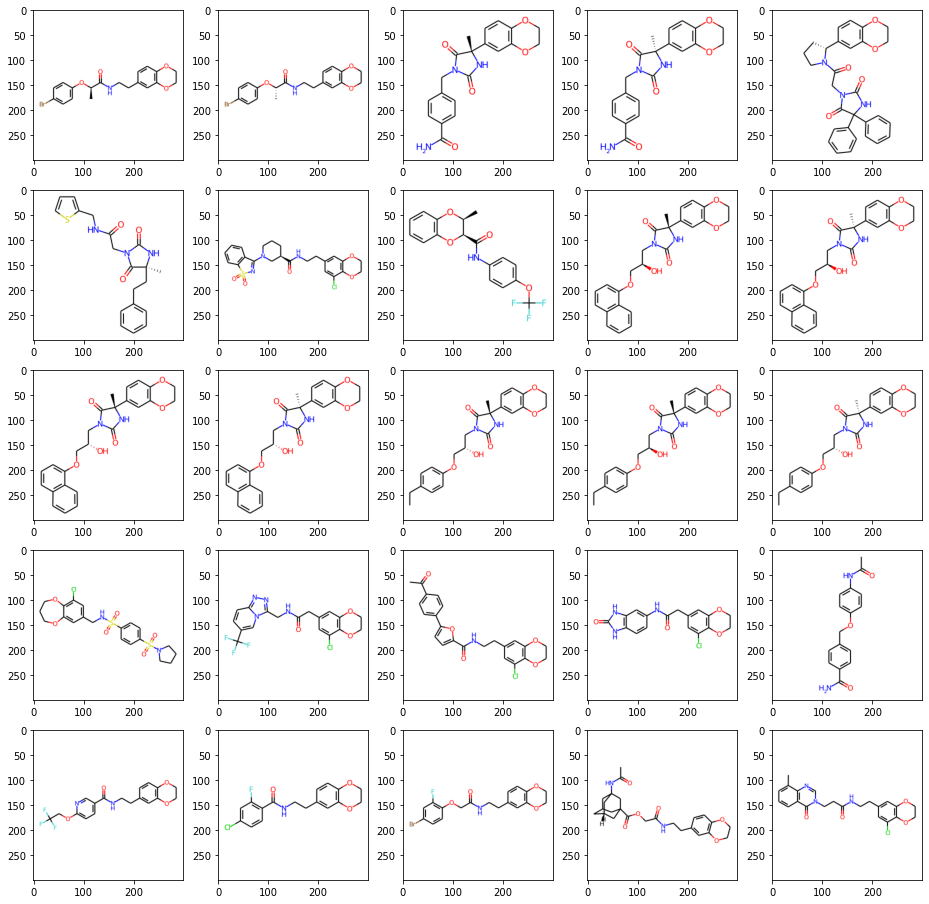

In [1039]:
_, axs = plt.subplots(5, 5, figsize=(16, 16))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

In [1042]:
answer_dist = df.loc[result].apply(f, axis=1)

(array([   5.,    3.,   30.,   58.,  186.,  934., 1906., 1033.,  511.,
         574.]),
 array([ 72. , 116.6, 161.2, 205.8, 250.4, 295. , 339.6, 384.2, 428.8,
        473.4, 518. ]),
 <BarContainer object of 10 artists>)

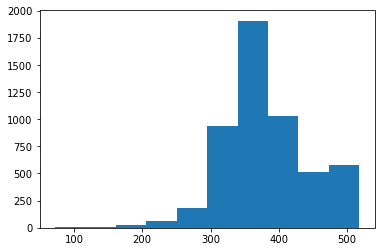

In [1044]:
plt.hist(answer_dist)

# Hashing

In [938]:
split_df = pd.read_csv("fingerprints.csv", index_col=0)

In [945]:
split_df = split_df.reindex(split_df.mean().sort_values(ascending=False).index, axis=1)

In [946]:
split_df

,594,2903,2799,1620,2871,3571,3347,3264,3327,3579,...,8,2771,17,2772,2773,2774,2775,2769,16,1867
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119692,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
119693,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
119694,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
119695,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [978]:
df = split_df.sample(n=1000)

In [979]:
df = df.T.drop_duplicates().T

In [980]:
def to_hash(bin_fingerprint):
    bit_chunks = np.array_split(bin_fingerprint, len(bin_fingerprint) // 32)
    num_chunks = map(lambda x: int("".join(map(str, x)), 2), bit_chunks)
    return list(num_chunks)

In [981]:
df['fingerprint'] = df.apply(to_hash2, axis = 1)

In [982]:
df = pd.DataFrame(df['fingerprint'].tolist())

In [1002]:
df

,0,1,2,3,4,5,6,7,8,9,...,67,68,69,70,71,72,73,74,75,76
0,8589934591,8589934591,8589934591,8589934591,8589934591,8589934550,8589934071,8573157363,4226019312,872413381,...,1210066944,4206656,4194304,1048576,524288,0,570949632,32,2281701376,0
1,8589934591,8589934591,8589934591,8589934591,8589934591,8589934591,8589803519,8589934591,8587837437,7511461887,...,8388864,69730304,524288,32,1048834,22528,8,0,0,0
2,8589934591,8589934591,8589934591,8589934591,8589934591,8589934591,8589934591,8589934591,8589869055,8522823661,...,3149824,4325376,1073741956,67111136,134217728,268435456,0,147456,0,0
3,8589934591,8589934591,8589934591,8589934591,8589869055,8589934591,8053062591,7497313791,7846866539,4971085051,...,1073741824,0,0,0,536870912,0,0,0,0,0
4,8589934591,8556380159,8589934591,6173982719,8581525421,4457916639,6384495871,6252303282,7398582708,7243269744,...,2147755008,16793856,538050561,2186289220,268438016,8912900,1310720,25231360,21504,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,8589934591,8589934591,8589934590,8589934591,8589664255,8589934527,8589934591,8573157325,8514428635,441106362,...,134219888,68288529,1141932048,2236440,268568598,1073774592,67108864,268435456,0,0
996,8589934591,8589934591,8589934591,8589934591,8589934591,8589934591,8589803519,8589934527,8589934463,3220963327,...,1142103857,537919488,1204093075,469926184,3495952433,1086697508,1769251843,2299873280,75498496,135266304
997,8589934591,8589934591,8589934591,8589934591,8589934591,8589934575,8052932605,4286011391,7499317116,8589791094,...,134808592,25864265,16779264,39854104,80020104,268500996,135267872,0,512,0
998,8589934591,8589934591,8589934591,8589934591,8589934591,8589934591,8589934591,8589934573,8589926399,8053063615,...,4194432,524416,12320,133632,268435456,0,0,2147483648,0,0


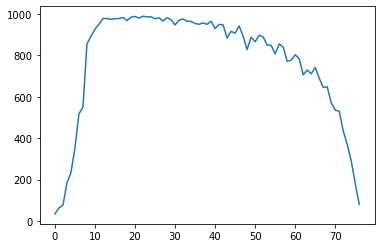

In [1000]:
plt.plot(df.apply(set).apply(len))

In [1013]:
df.groupby([0, 1, 3, 75, 76]).size().values.size

451